In [1]:
from IPython.display import display, Markdown

scenario_info = """"""
scenario_folder = "scenario_01"

In [2]:

display(Markdown("""
# Scenario Analysis - "Grid modelling to assess electrofuels supply potential - The impact of electrofuels on the US electricity grid"
"""))
display(Markdown(scenario_info))


# Scenario Analysis - "Grid modelling to assess electrofuels supply potential - The impact of electrofuels on the US electricity grid"


---

## 1. Setup and Data Loading

*This section handles the initial setup, including importing necessary libraries and loading the solved PyPSA-Earth networks.*

### 1.1. Import Libraries

In [3]:
!pip install plotly -qq

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pycountry

import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from pathlib import Path

import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.patches import Wedge
from matplotlib.patches import Patch
import matplotlib.path as mpath
import matplotlib.transforms as mtransforms
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.font_manager import FontProperties
from IPython.display import display, HTML, Markdown
from matplotlib.font_manager import FontProperties
from functools import reduce
from collections import defaultdict
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import LineString
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import yaml
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")

from _helpers import (
    attach_grid_region_to_buses, attach_state_to_buses, compute_demand,
    compute_data_center_load, fill_missing_color, preprocess_res_ces_share_eia,
    fill_missing_nice_names, update_ac_dc_bus_coordinates, assign_location,
    create_hydrogen_capacity_map, print_hydrogen_capacity_summary, create_ft_capacity_by_grid_region_map,
    create_ft_capacity_by_state_map, compute_h2_capacities, plot_h2_capacities_by_state, plot_h2_capacities_by_grid_region,
    calculate_dispatch, plot_electricity_dispatch, compute_and_plot_load, calculate_lcoe_summary_and_map,
    plot_lcoe_map_by_grid_region, plot_h2_capacities_map, plot_lcoh_maps_by_grid_region,
    calculate_weighted_lcoh_table_by_year, calculate_total_generation_by_carrier,
    plot_hydrogen_dispatch, plot_network_generation_and_transmission, plot_stacked_costs_by_year_plotly,
    compute_aviation_fuel_demand, compute_emissions_from_links, compute_installed_capacity_by_carrier,
    compute_emissions_grouped, compute_emissions_by_state, plot_emissions_maps_by_group, evaluate_res_ces_by_state,
    compute_system_costs, plot_stacked_costs_by_year, assign_macro_category, calculate_total_inputs_outputs_ft, compute_ekerosene_production_cost_by_region,
    plot_float_bar_lcoe_dispatch_ranges, compute_line_expansion_capacity
)

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [5]:
with open('plotting.yaml', 'r') as file:
    plotting = yaml.safe_load(file)

tech_colors = plotting['tech_colors']
nice_names = plotting['nice_names']
rename_techs_capex = plotting['rename_tech_capex']
rename_techs_opex = plotting['rename_tech_opex']
rename_tech_colors = plotting['renamed_tech_colors']
categories_capex = plotting['categories_capex']
categories_opex = plotting['categories_opex']


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', None)    
pd.set_option('display.max_colwidth', None)

import plotly.io as pio
pio.renderers.default = 'colab'

### 1.2. Load Solved Network(s)

The `scenario_dir` variable can be used to switch to a different scenario. The base year results are common for all the scenarios.

In [7]:

# -----------------------------
# Project folder path
# -----------------------------
project_root = Path().resolve()

# -----------------------------
# Base year network path
# -----------------------------
base_year_file = project_root / "results" / "base_year" / "elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc"

networks = {
    "Base_2023": pypsa.Network(base_year_file)
}

# -----------------------------
# Scenario folder path (single scenario)
# -----------------------------
scenario_dir = project_root / "results" / "scenarios" / f"{scenario_folder}" #change the number to choose the scenario of your interest

## Folder structure
#  project_root/
#  └── notebooks/
#       ├── scenario_analysis.ipynb
#       └── results/
#            ├── base_year/
#            │   ├── elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc
#            └── scenarios/
#                 ├── scenario_01/
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc
#                 │   └── elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc
#                 ├── scenario_02/
#                 ├── ...
#                 ├── scenario_10/

years = [2030, 2035, 2040]

# -----------------------------
# Upload available networks per year
# -----------------------------
for year in years:
    file_name = f"elec_s_100_ec_lv1_3H_3H_{year}_0.071_AB_10export.nc"
    file_path = scenario_dir / file_name

    if file_path.exists():
        scenario_name = scenario_dir.name  # e.g., "scenario_01"
        key = f"{scenario_name}_{year}"
        networks[key] = pypsa.Network(file_path)
        print(f"Loaded: {key}")
    else:
        print(f"Missing: {file_path.relative_to(project_root)}")

network_names = list(networks.keys())
print("\n Uploaded networks:")
print(list(networks.keys()))

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lv1_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loaded: scenario_01_2030


INFO:pypsa.io:Imported network elec_s_100_ec_lv1_3H_3H_2035_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loaded: scenario_01_2035


INFO:pypsa.io:Imported network elec_s_100_ec_lv1_3H_3H_2040_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loaded: scenario_01_2040

 Uploaded networks:
['Base_2023', 'scenario_01_2030', 'scenario_01_2035', 'scenario_01_2040']


In [8]:
# # -----------------------------
# # Project folder path
# # -----------------------------
# project_root = Path().resolve()

# # -----------------------------
# # Base year network path
# # -----------------------------
# base_year_file = project_root / "results" / "base_year" / "elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc"

# networks = {
#     "Base_2023": pypsa.Network(base_year_file)
# }

# # -----------------------------
# # Scenario folder path (single scenario)
# # -----------------------------
# scenario_dir = project_root / "results" / "scenarios" / f"{scenario_folder}" #change the number to choose the scenario of your interest

# ## Folder structure
# #  project_root/
# #  └── notebooks/
# #       ├── scenario_analysis.ipynb
# #       └── results/
# #            ├── base_year/
# #            │   ├── elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc
# #            └── scenarios/
# #                 ├── scenario_01/
# #                 │   ├── elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc
# #                 │   ├── elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc
# #                 │   └── elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc
# #                 ├── scenario_02/
# #                 ├── ...
# #                 ├── scenario_10/

# years = [2030, 2035, 2040]

# # -----------------------------
# # Upload available networks per year
# # -----------------------------
# for year in years:
#     file_name = f"elec_s_100_ec_lv1.0_3H_3H_{year}_0.071_AB_10export.nc"
#     file_path = scenario_dir / file_name

#     if file_path.exists():
#         scenario_name = scenario_dir.name  # e.g., "scenario_01"
#         key = f"{scenario_name}_{year}"
#         networks[key] = pypsa.Network(file_path)
#         print(f"Loaded: {key}")
#     else:
#         print(f"Missing: {file_path.relative_to(project_root)}")

# network_names = list(networks.keys())
# print("\n Uploaded networks:")
# print(list(networks.keys()))

In [9]:
grid_region_shapes_path = project_root / "needs_grid_regions_aggregated.geojson"
state_shapes_path = project_root / "gadm41_USA_1.json"

regions_onshore = gpd.read_file(grid_region_shapes_path)

In [10]:
for network in networks.keys():
    attach_grid_region_to_buses(networks[network], grid_region_shapes_path)
    attach_state_to_buses(networks[network], state_shapes_path)

---

## 2. Total system cost

In [11]:
all_system_costs = []

for name_tag, network in networks.items():
    df_yearly = compute_system_costs(
        network=network,
        rename_capex=rename_techs_capex,
        rename_opex=rename_techs_opex,
        name_tag=name_tag
    )
    all_system_costs.append(df_yearly)

df_system_costs_all = pd.concat(all_system_costs, ignore_index=True)

df_system_costs_all['macro_category'] = df_system_costs_all.apply(
    lambda row: assign_macro_category(row, categories_capex, categories_opex),
    axis=1
)

# Plot CAPEX
plot_stacked_costs_by_year_plotly(df_system_costs_all, "Capital expenditure", tech_colors=rename_tech_colors)

# Plot OPEX
plot_stacked_costs_by_year_plotly(df_system_costs_all, "Operational expenditure", tech_colors=rename_tech_colors)
plt.show()


## 3. Electricity demand

*This section illustrates results concerning electricity demand across the different sectors in the model, with a specific focus on data centers.*

### 3.1. Electricity demand by service
*This section reports results for electricity demand related to the different sectors, providing a comparison against the NREL Electrification Futures Studies (EFS) scenarios.*

In [12]:
networks.keys()

dict_keys(['Base_2023', 'scenario_01_2030', 'scenario_01_2035', 'scenario_01_2040'])

In [13]:
# Industrial processes consuming AC electricity
target_processes = [
    "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
    "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
    "dry clinker", "cement finishing", "dry clinker CC"
]

# Static and dynamic loads
static_load_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
dynamic_load_carriers = ["AC", "services electricity", "land transport EV", "data center"]

demand = pd.DataFrame(columns=networks.keys(),
                      index=dynamic_load_carriers + static_load_carriers + ["total demand"])
demand.index.name = "Load type (TWh)"

for name, n in networks.items():
    nhours = n.snapshot_weightings.objective.sum()

    # Static loads
    static_totals = (
        n.loads.groupby("carrier").sum().p_set
        .reindex(static_load_carriers)
        .fillna(0)
    )
    static_load_twh = static_totals.sum() * nhours / 1e6

    # Industrial AC
    process_links = n.links[n.links.carrier.isin(target_processes)]
    ac_input_links = process_links[process_links.bus0.map(n.buses.carrier) == "AC"].index
    ind_ac_profile = n.links_t.p0[ac_input_links].sum(axis=1)
    ind_ac_twh = (ind_ac_profile * n.snapshot_weightings.objective).sum() / 1e6

    # Non-industrial AC
    ac_loads = n.loads[n.loads.carrier == "AC"]
    industrial_ac_buses = n.links.loc[ac_input_links, "bus0"].unique()
    ac_non_ind_idx = ac_loads[~ac_loads.bus.isin(industrial_ac_buses)].index
    ac_profile = n.loads_t.p_set[ac_non_ind_idx.intersection(n.loads_t.p_set.columns)].sum(axis=1)
    ac_twh = (ac_profile * n.snapshot_weightings.objective).sum() / 1e6 - ind_ac_twh

    # Services and EVs
    serv_idx = [i for i in n.loads[n.loads.carrier == "services electricity"].index
                if i in n.loads_t.p_set.columns]
    ev_idx = [i for i in n.loads[n.loads.carrier == "land transport EV"].index
              if i in n.loads_t.p_set.columns]
    serv_profile = n.loads_t.p_set[serv_idx].sum(axis=1) if serv_idx else 0
    ev_profile = n.loads_t.p_set[ev_idx].sum(axis=1) if ev_idx else 0
    serv_twh = (serv_profile * n.snapshot_weightings.objective).sum() / 1e6
    ev_twh = (ev_profile * n.snapshot_weightings.objective).sum() / 1e6

    # Data centers
    data_center_p_set_sum = n.loads.loc[n.loads.carrier == "data center", "p_set"].sum()
    data_center_twh = data_center_p_set_sum * nhours / 1e6

    # Other electricity (included in industrial consumption)
    other_idx = [i for i in n.loads[n.loads.carrier == "other electricity"].index
                 if i in n.loads_t.p_set.columns]
    other_profile = n.loads_t.p_set[other_idx].sum(axis=1) if other_idx else 0
    other_twh = (other_profile * n.snapshot_weightings.objective).sum() / 1e6

    industry_static_twh = static_totals.get("industry electricity", 0) * nhours / 1e6
    industry_elec_twh = industry_static_twh + ind_ac_twh + other_twh

    demand.loc["rail transport electricity", name] = static_totals.get("rail transport electricity", 0) * nhours / 1e6
    demand.loc["agriculture electricity", name] = static_totals.get("agriculture electricity", 0) * nhours / 1e6
    demand.loc["industry electricity", name] = industry_elec_twh
    demand.loc["AC", name] = ac_twh
    demand.loc["services electricity", name] = serv_twh
    demand.loc["land transport EV", name] = ev_twh
    demand.loc["data center", name] = data_center_twh
    demand.loc["total demand", name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh + data_center_twh + other_twh
    )
    demand.loc["total demand no data center", name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh + other_twh
    )


In [14]:
# NREL reference values (2023, 2030, 2040)
nrel_data_medium = {
    "AC (residential + some industrial processes)": [1360.81, 1359.91, 1392.19],
    "services electricity": [1381.11, 1398.69, 1579.71],
    "land transport EV":    [13.10,	275.97,	714.41],
    "rail transport electricity": [7.29, 7.64, 8.29],
    "agriculture electricity": [np.nan, np.nan, np.nan],
    "industry electricity": [1036.81, 1109.69, 1213.94],
    "data center": [np.nan, np.nan, np.nan],
    "total demand (incl. data centers)": [3799.12, 4293.30, 5072.86],
    "total demand (excl. data centers)": [3799.12, 4293.30, 5072.86],
}

nrel_data_high = {
    "AC (residential + some industrial processes)": [1360.81, 1395.21, 1529.51],
    "services electricity": [1381.11, 1470.10, 1673.71],
    "land transport EV":    [13.10, 349.15, 1039.76],
    "rail transport electricity": [7.29, 9.96, 12.71],
    "agriculture electricity": [np.nan, np.nan, np.nan],
    "industry electricity": [1036.81, 1152.90, 1286.24],
    "data center": [np.nan, np.nan, np.nan],
    "total demand (incl. data centers)": [3799.12, 4377.32,	6713.68],
    "total demand (excl. data centers)": [3799.12, 4377.32,	6713.68],
}

# Mapping PyPSA names to NREL names
row_rename_map = {
    "AC": "AC (residential + some industrial processes)",
    "total demand": "total demand (incl. data centers)",
    "total demand no data center": "total demand (excl. data centers)"
}

# Extract years from network names
network_years = {}
for key in networks:
    match = re.search(r'(\d{4})', key)
    if match:
        network_years[int(match.group(1))] = key

# Determine the current scenario from network names (e.g., scenario_05)
scenario_keys = [k for k in networks if "scenario_" in k]
if scenario_keys:
    current_scenario = scenario_keys[0].split("_")[0] + "_" + scenario_keys[0].split("_")[1]
else:
    current_scenario = None

# Select appropriate NREL reference data based on scenario
if current_scenario in ["scenario_05", "scenario_06"]:
    nrel_data = nrel_data_high
else:
    nrel_data = nrel_data_medium

# Prepare the comparison table
rows = list(nrel_data.keys())
columns = pd.MultiIndex.from_product(
    [sorted(network_years.keys()), ["PyPSA-Earth", "NREL", "diff %"]]
)
comparison_df = pd.DataFrame(index=rows, columns=columns)

# Populate the comparison values
for year, net_key in network_years.items():
    for row in rows:
        pypsa_row = {v: k for k, v in row_rename_map.items()}.get(row, row)
        
        pypsa_val = demand.at[pypsa_row, net_key] if pypsa_row in demand.index else np.nan
        nrel_vals = nrel_data.get(row, None)

        if nrel_vals and year in [2023, 2030, 2040]:
            col_idx = [2023, 2030, 2040].index(year)
            nrel_val = nrel_vals[col_idx]
        else:
            nrel_val = np.nan

        comparison_df.at[row, (year, "PyPSA-Earth")] = pypsa_val
        comparison_df.at[row, (year, "NREL")] = nrel_val

        if pd.notna(pypsa_val) and pd.notna(nrel_val) and nrel_val != 0:
            diff = 100 * (pypsa_val - nrel_val) / nrel_val
        else:
            diff = np.nan
        comparison_df.at[row, (year, "diff %")] = diff

# Style function to highlight significant differences
def highlight_diff(val):
    if pd.isna(val):
        return ''
    if val > 10:
        return 'background-color: #ffcccc'  # light red
    elif val < -10:
        return 'background-color: #cce5ff'  # light blue
    else:
        return 'background-color: #d4edda'  # light green

# Apply styling to the diff columns
styled = comparison_df.style
for year in network_years:
    styled = styled.applymap(highlight_diff, subset=pd.IndexSlice[:, (year, "diff %")])
styled = styled.format(na_rep="N/A", precision=2)

# Display final table
print("\n Electric load by sector (TWh/year)")
display(styled)


 Electric load by sector (TWh/year)


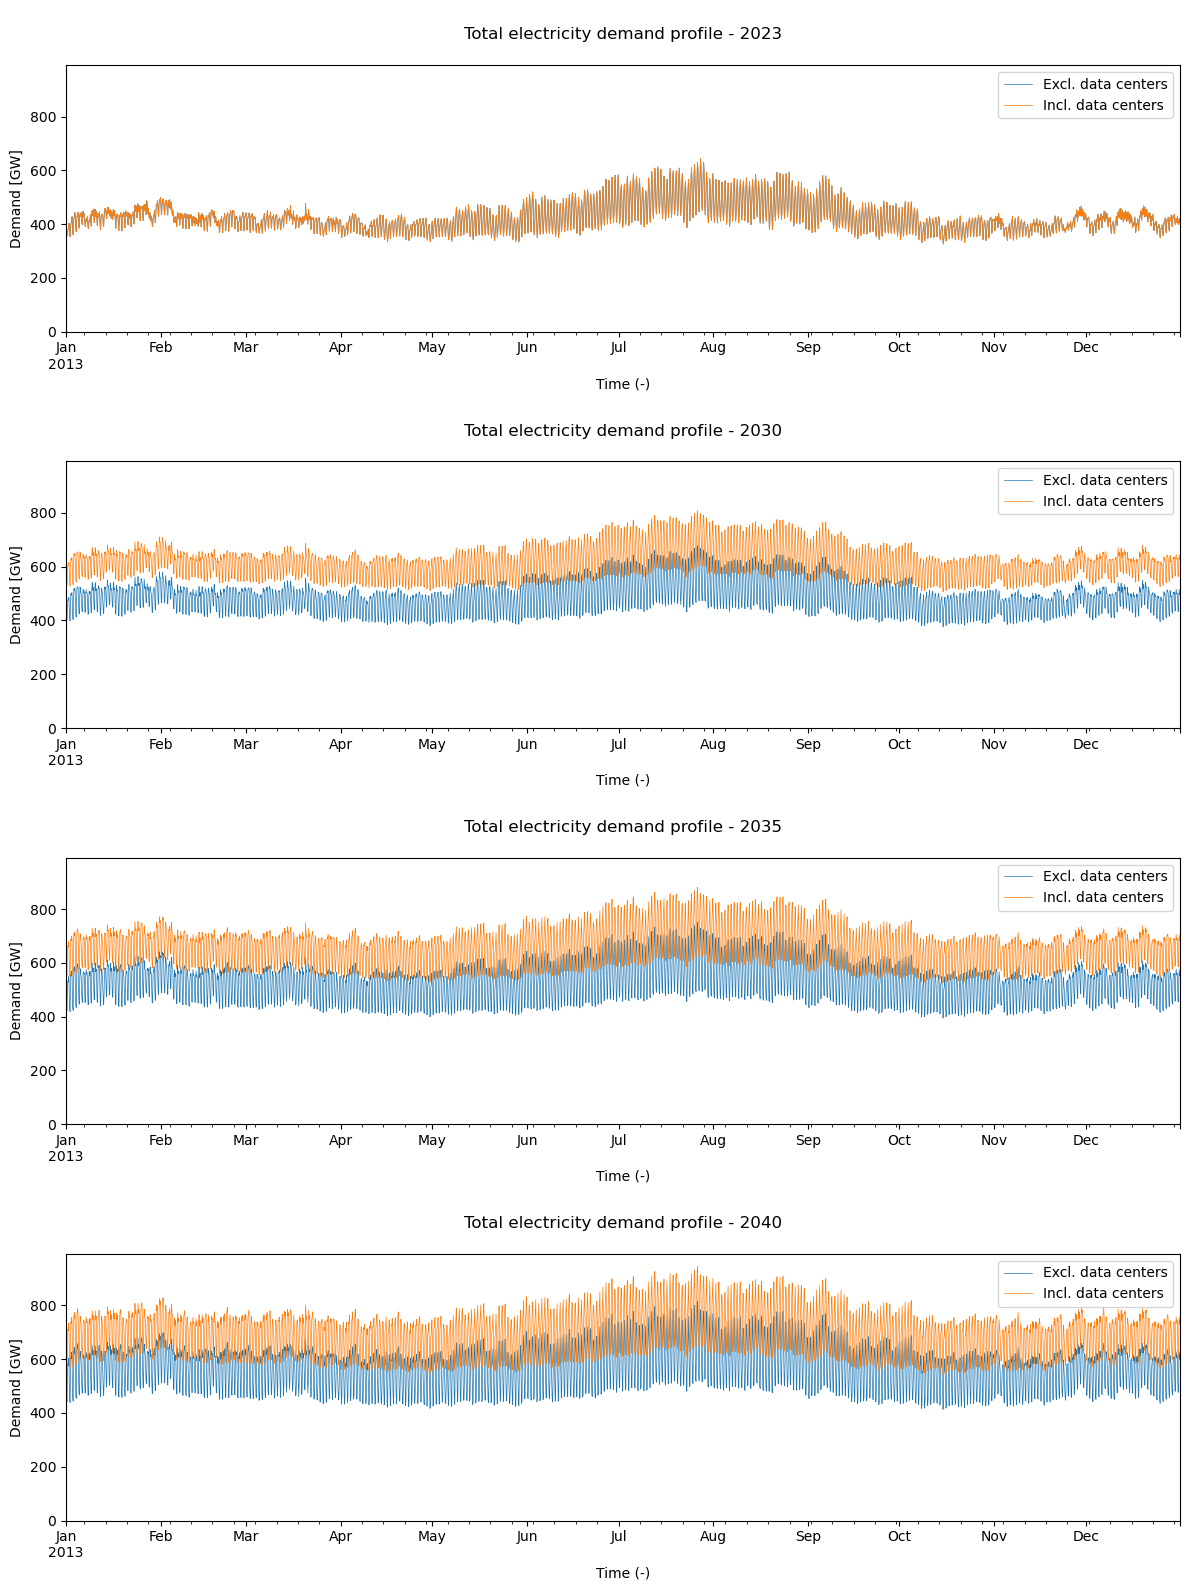

In [15]:
# Extract years from network names
years = {}
for name in networks:
    match = re.search(r"\d{4}", name)
    if match:
        years[int(match.group())] = name
years = dict(sorted(years.items()))  # sort by year

# Compute y-axis max (in GW) and build demand profiles
y_max = 0
demand_profiles_incl = {}
demand_profiles_excl = {}

for year, name in years.items():
    n = networks[name]
    nhours = n.snapshot_weightings.objective.sum()

    # Dynamic loads: AC, services, EV, other electricity
    dynamic_loads = n.loads[n.loads.carrier.isin(["AC", "services electricity", "land transport EV", "other electricity"])]
    dynamic_idx = dynamic_loads.index.intersection(n.loads_t.p_set.columns)
    dyn_profile = n.loads_t.p_set[dynamic_idx].sum(axis=1)

    # Static loads: rail, agriculture, industry
    static_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
    static_load = n.loads[n.loads.carrier.isin(static_carriers)]
    static_sum = static_load.groupby("carrier").sum()["p_set"].sum()  # MW
    static_profile = pd.Series(static_sum, index=n.snapshots)

    # Data centers (flat profile if present)
    if "data center" in n.loads.carrier.values:
        dc_sum = n.loads[n.loads.carrier == "data center"]["p_set"].sum()
        dc_profile = pd.Series(dc_sum, index=n.snapshots)
    else:
        dc_profile = 0

    # Total profiles (in GW)
    profile_excl = (dyn_profile + static_profile) / 1000
    profile_incl = (dyn_profile + static_profile + dc_profile) / 1000

    demand_profiles_excl[year] = profile_excl
    demand_profiles_incl[year] = profile_incl

    y_max = max(y_max, profile_incl.max())

y_max *= 1.05  # add 5% margin

# Plot profiles for each year
fig, axes = plt.subplots(nrows=len(years), figsize=(12, 4 * len(years)), sharey=True)

if len(years) == 1:
    axes = [axes]  # ensure list if only one subplot

for ax, (year, name) in zip(axes, years.items()):
    demand_profiles_excl[year].plot(ax=ax, linewidth=0.5, color="tab:blue", label="Excl. data centers")
    demand_profiles_incl[year].plot(ax=ax, linewidth=0.5, color="tab:orange", label="Incl. data centers")

    ax.set_title(f"\nTotal electricity demand profile - {year}\n")
    ax.set_xlabel("Time (-)")
    ax.set_ylabel("Demand [GW]")
    ax.set_ylim(0, y_max)
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


### 3.2. Data center loads
*This section shows the subdivision of data center loads across the different States / Grid Regions.*


Skipping 2023: No data centers demand



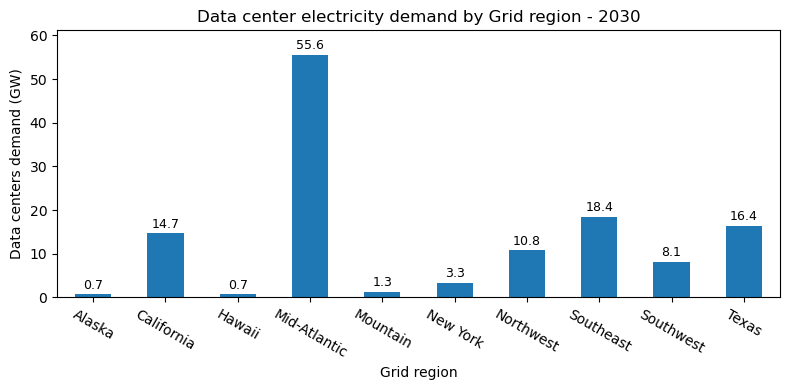

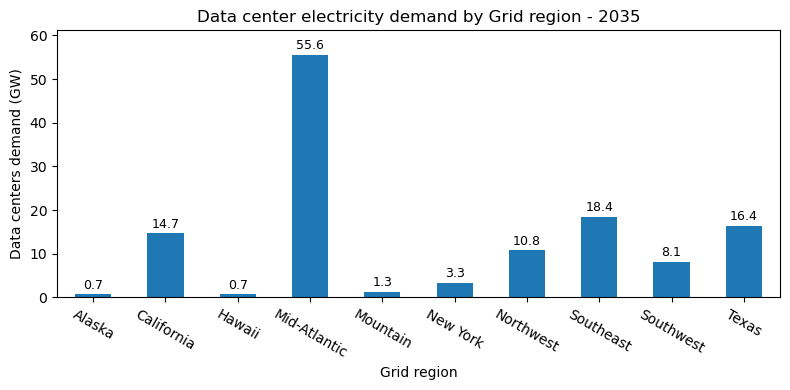

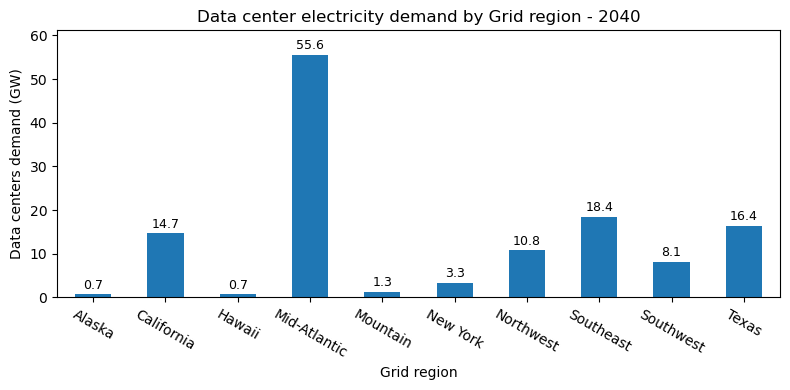

In [16]:
data_center_load = {}
for key, net in networks.items():
    year_match = re.search(r"\d{4}", key)
    short_key = year_match.group() if year_match else key 
    data_center_load[short_key] = compute_data_center_load(net)
    
# Compute the maximum value to normalize the y-axis
max_val = 0
for df in data_center_load.values():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)
    demand_by_grid_region = demand_by_grid_region[demand_by_grid_region > 0]
    if not demand_by_grid_region.empty:
        max_val = max(max_val, demand_by_grid_region.max())

ymax = max(max_val * 1.1, 1)

# Main loop to generate plots
for year, df in data_center_load.items():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)
    demand_by_grid_region = demand_by_grid_region[demand_by_grid_region > 0]

    if demand_by_grid_region.empty:
        print(f"\nSkipping {year}: No data centers demand\n")
        continue

    ax = demand_by_grid_region.plot(
        kind="bar",
        title=f"Data center electricity demand by Grid region - {year}",
        ylabel="Data centers demand (GW)",
        xlabel="Grid region",
        figsize=(8, 4),
        legend=False
    )

    # Add text labels on top of bars
    for i, value in enumerate(demand_by_grid_region.values):
        ax.text(
            i,
            value + ymax * 0.01,  # Slightly above the bar
            f"{value:.1f}",       # Format with 1 decimal place
            ha="center",
            va="bottom",
            fontsize=9,
            rotation=0
        )

    ax.set_ylim(0, ymax)
    plt.xticks(rotation=-30)
    plt.tight_layout()
    plt.show()


Skipping 2023: No data centers demand



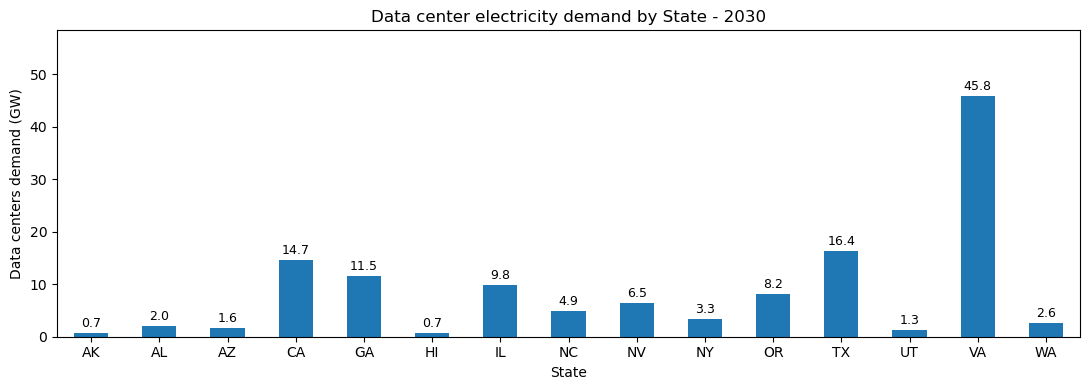

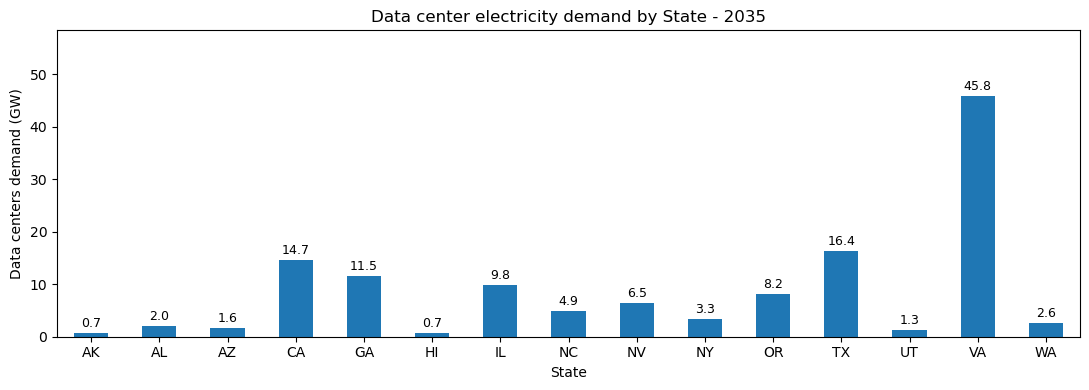

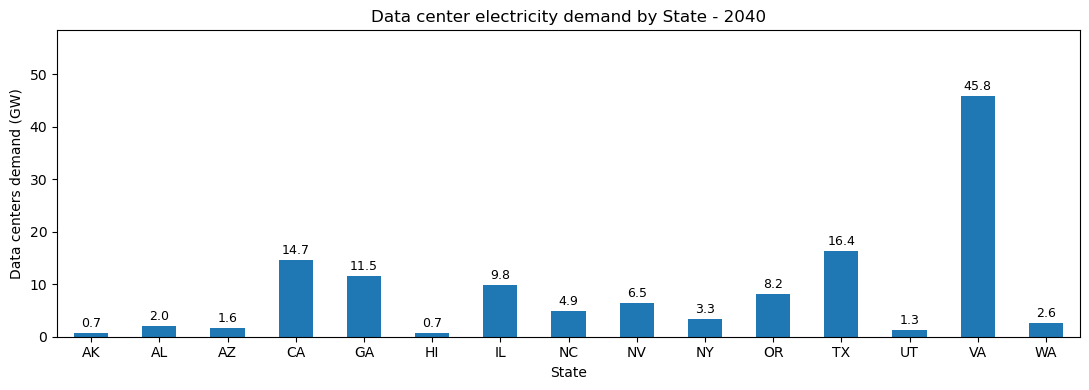

In [17]:
for key, df in data_center_load.items():    
    year_match = re.search(r"\d{4}", key)
    short_key = year_match.group() if year_match else key 
    demand_by_state = df.groupby("state")["p_set"].sum().div(1e3)
    demand_by_state = demand_by_state[demand_by_state > 0]

    if demand_by_state.empty:
        print(f"\nSkipping {key}: No data centers demand\n")
        continue

    # Extract year from key assuming format like "scenario_01_2030"
    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"

    ax = demand_by_state.plot(
        kind="bar",
        title=f"Data center electricity demand by State - {year}",
        ylabel="Data centers demand (GW)",
        xlabel="State",
        figsize=(11, 4),
        legend=False
    )

    # Add text labels on top of bars
    for i, value in enumerate(demand_by_state.values):
        ax.text(
            i,
            value + max_val * 0.01,  # Slightly above the bar
            f"{value:.1f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    ax.set_ylim(0, max_val * 1.05)
    plt.xticks(rotation=0) 
    plt.tight_layout()
    plt.show()

---

## 4. Installed capacity

*Here, we analyze the optimal installed capacities of generation, storage, and conversion technologies as determined by the model.*

### 4.1. Installed electricity capacity
*A map showing the total installed capacity (in GW) for each electricity generation carrier (e.g., Solar, Onshore Wind, Offshore Wind) at different locations.*

In [18]:
# regions_onshore = gpd.read_file(grid_region_shapes_path)

# # Prepare Data for Plotting
# gen_p_nom_opt = n.generators.groupby(["bus", "carrier"]).p_nom_opt.sum()
# sto_p_nom_opt = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
# bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt])
# bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]

# line_values = n.lines.s_nom
# links_values = n.links[n.links.carrier == "DC"].p_nom

# n = update_ac_dc_bus_coordinates(n)

# # Find carriers that need a color
# carriers_to_plot = bus_carrier_capacity.index.get_level_values(1).unique()
# for carrier in carriers_to_plot:
#     if carrier not in n.carriers.index:
#         n.add("Carrier", carrier)

# for idx in tech_colors.keys():
#     n.carriers.loc[idx, "color"] = tech_colors[idx]
    
# fill_missing_nice_names(n, nice_names)

# # Assign colors from the dictionary, using 'gray' for any not found
# n.carriers["color"] = n.carriers.index.map(tech_colors)
# n.carriers.color.fillna("gray", inplace=True)

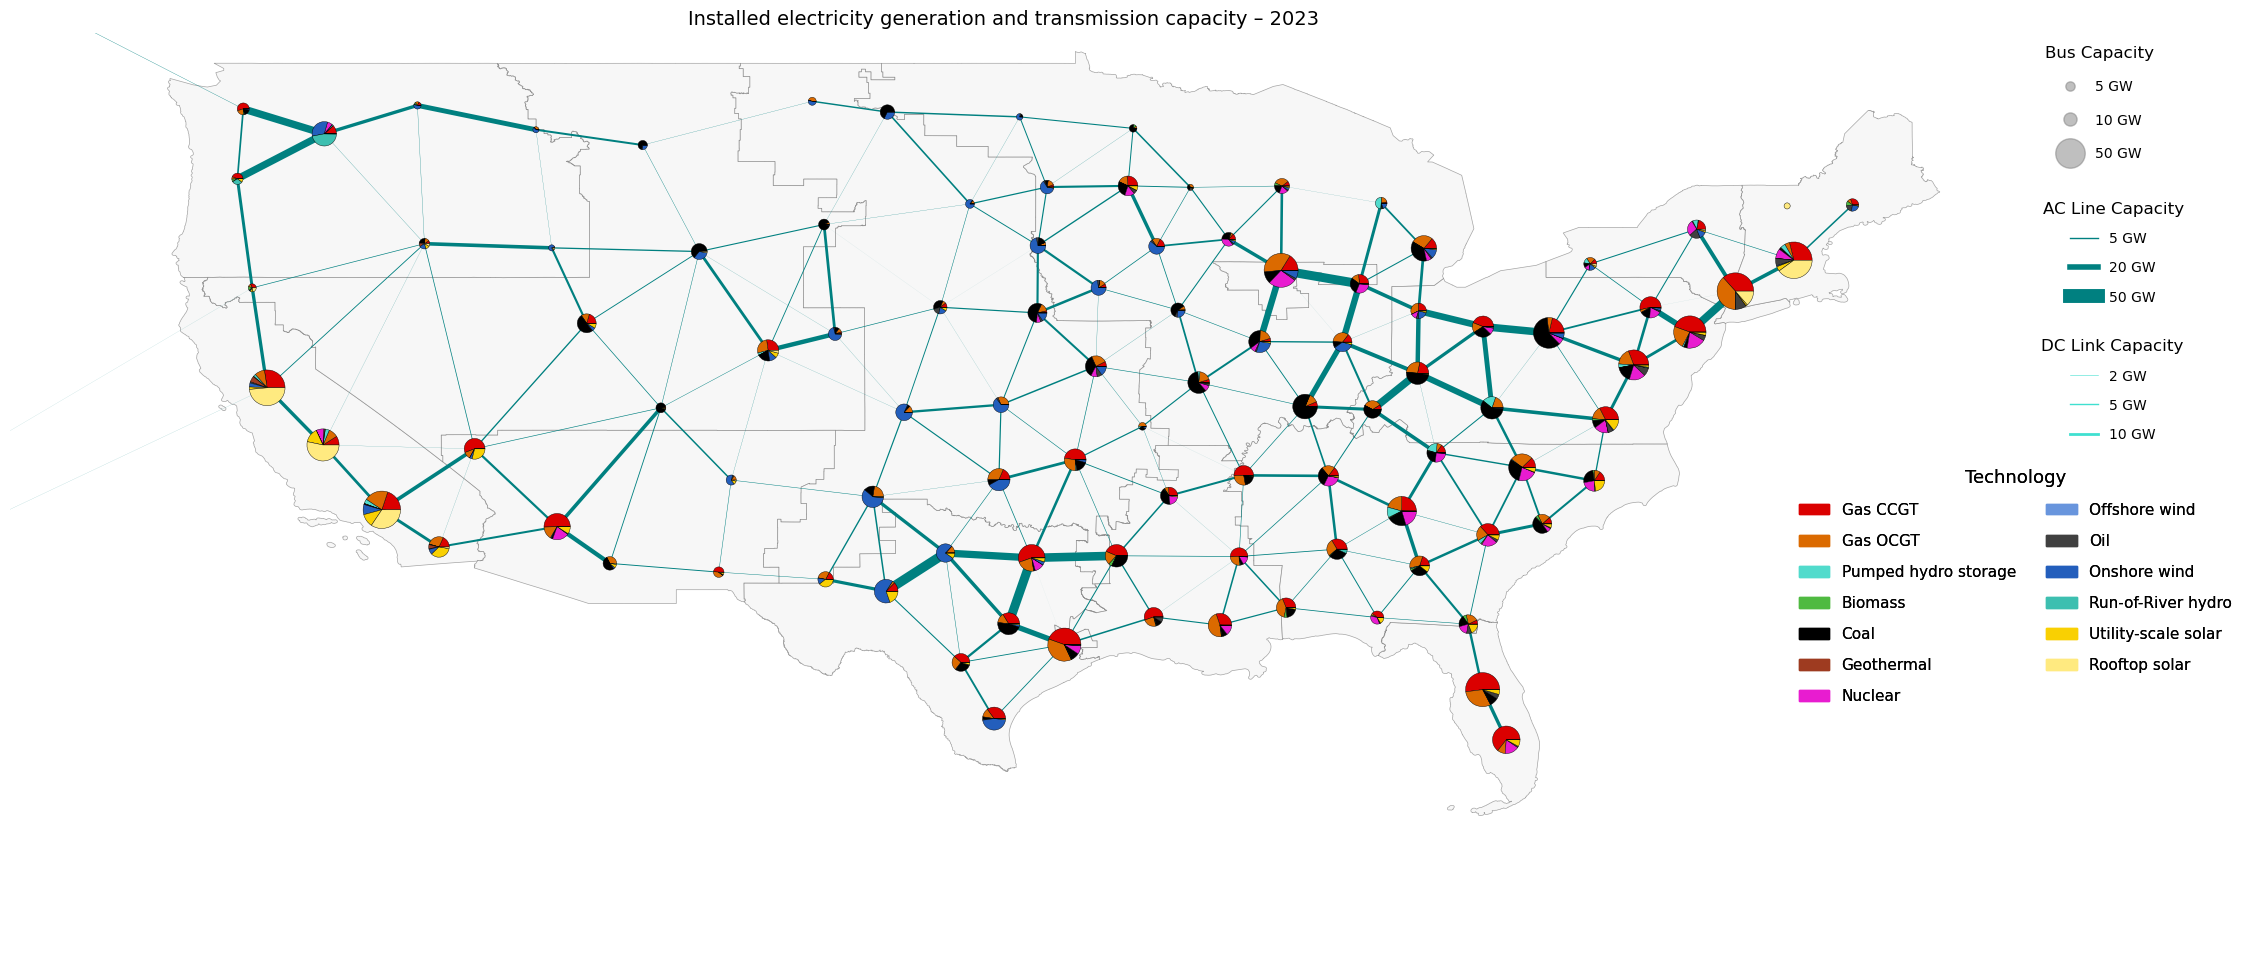

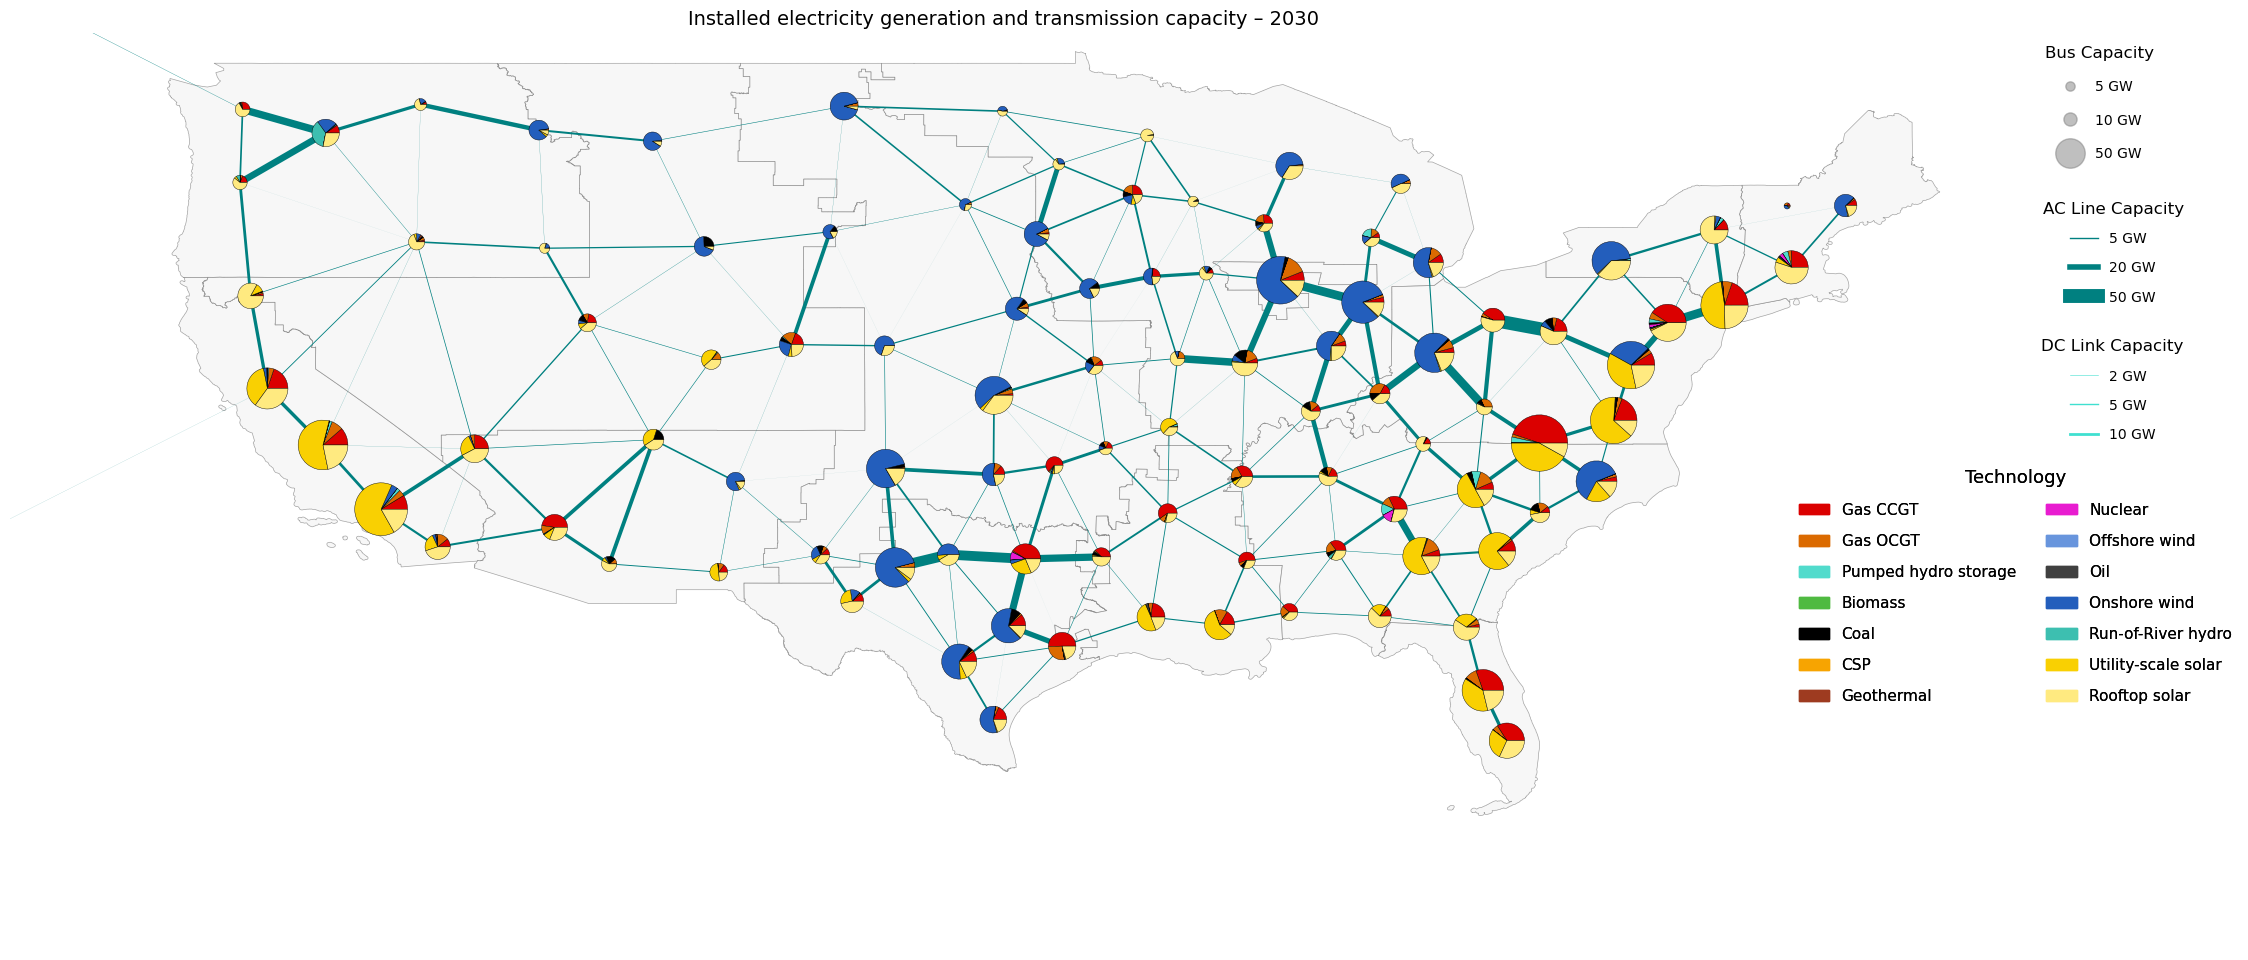

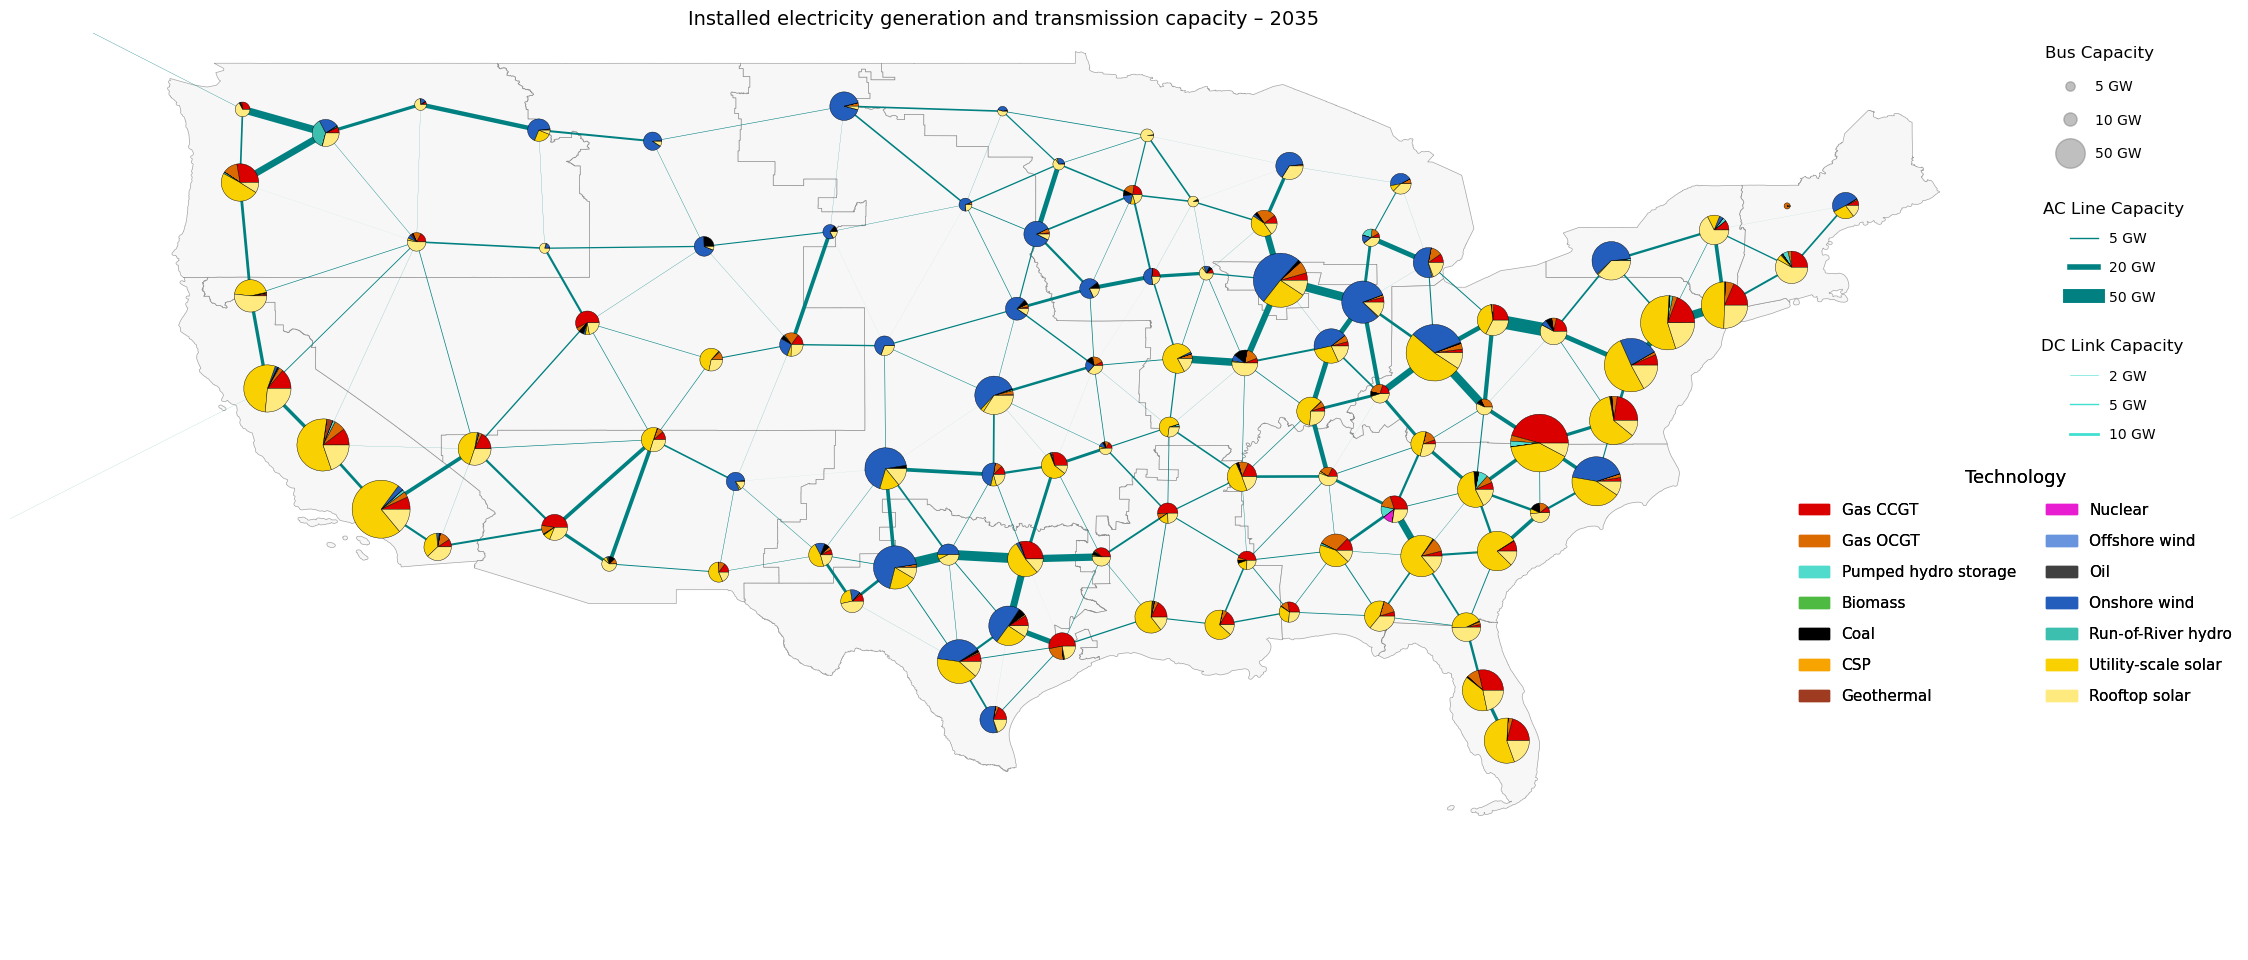

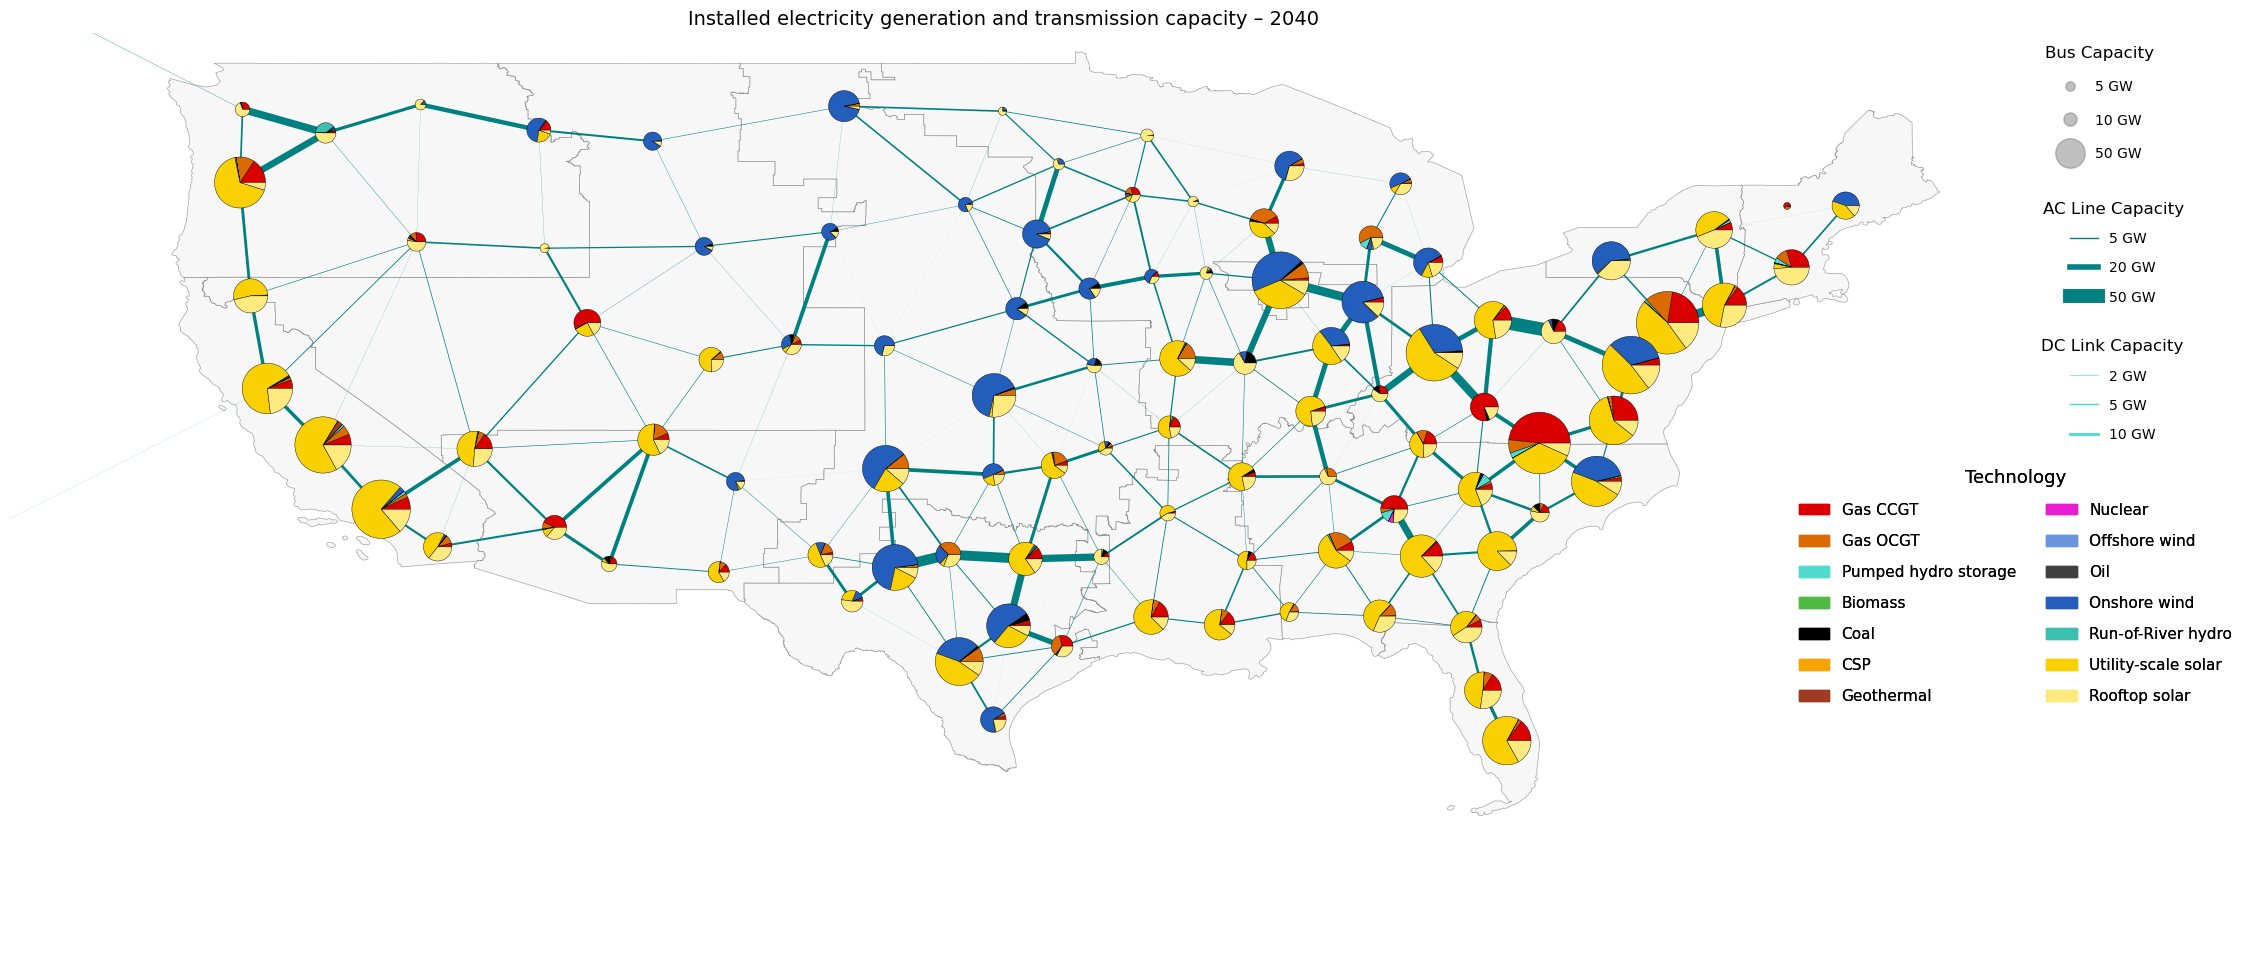

In [19]:
for key, n in networks.items():
    plot_network_generation_and_transmission(n, key, tech_colors, nice_names, regions_onshore)

In [20]:
df_capacity = compute_installed_capacity_by_carrier(networks, nice_names=nice_names)


Installed capacity by technology (GW)



,2023,2030,2035,2040
carrier,,,,
Gas CCGT,313.97,332.44,350.69,318.82
Gas OCGT,242.72,144.85,159.46,184.96
Pumped hydro storage,22.01,21.98,21.98,21.98
Biomass,9.01,2.22,2.05,1.64
Coal,226.98,43.44,33.45,23.88
Geothermal,3.89,1.19,3.99,3.71
Conventional hydro,69.54,58.08,58.08,58.08
Nuclear,99.96,7.35,2.54,1.27
Oil,32.52,3.41,2.19,0.32


In [21]:
carrier_capacity_df = compute_installed_capacity_by_carrier(networks, display_result=False)

# Get the tech order and colors
carrier_order = list(carrier_capacity_df.index)
color_list = [tech_colors.get(carrier, 'gray') for carrier in carrier_order]

# Create the Plotly stacked bar chart
fig = go.Figure()

for carrier, color in zip(carrier_order, color_list):
    fig.add_trace(go.Bar(
        name=nice_names.get(carrier, carrier),  # Pretty name
        x=carrier_capacity_df.columns.astype(str),  # Years
        y=carrier_capacity_df.loc[carrier],
        marker_color=color,
        width=0.6,
        hovertemplate=f"%{{x}}<br>{nice_names.get(carrier, carrier)}: %{{y:.2f}}GW <extra></extra>"
    ))

fig.update_layout(
    barmode='stack',
    title=dict(
        text="Installed capacity by technology",
        x=0.5,            
        xanchor='center',
        font=dict(size=24)
    ),
    xaxis_title="Year (-)",
    yaxis_title="Installed capacity (GW)",
    legend_title="Technology",
    template="plotly_white",
    width=1400,
    height=700, 
    xaxis=dict(
        title="Year (-)",
        tickangle=0,
        showline=True,    
        linecolor='black',
    ),
    yaxis=dict(
        title="Installed capacity (GW)",
        showline=True, 
        linecolor='black',
    ),
    font=dict(
        size=16
    ),
)
fig.add_shape(
    type="rect",
    xref="paper", yref="paper",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="black", width=1),
    layer="below"
)

fig.show()


### 4.2. Transmission Line Expansion

In [22]:
for network_name, n in networks.items():
    print(f"\nCapacity expansion for {network_name}:")
    display(compute_line_expansion_capacity(n)[0].T)


Capacity expansion for Base_2023:


grid_region,California,Delta,Florida,Hawaii,Mid-Atlantic,Midwest,Mountain,New England,New York,Northwest,Plains,Southeast,Southwest,Texas
s_nom,47.792651,77.251380,20.834155,0.592102,369.010532,263.228040,58.122031,20.761539,21.455303,137.670318,112.646765,167.963523,83.474032,185.054084
s_nom_opt,47.792652,77.251382,20.834155,0.592102,369.010535,263.228043,58.122031,20.761539,21.455303,137.670321,112.646766,167.963524,83.474033,185.054085



Capacity expansion for scenario_01_2030:


grid_region,Alaska,California,Delta,Florida,Hawaii,Mid-Atlantic,Midwest,Mountain,New England,New York,Northwest,Plains,Southeast,Southwest,Texas
s_nom,1.156274,46.586105,56.948999,30.363639,0.335152,341.237721,330.579542,54.626397,18.256279,21.455303,109.67732,138.084789,187.350991,84.936411,205.791045
s_nom_opt,1.156274,46.586105,56.948999,30.363639,0.335152,341.237721,330.579542,54.626397,18.256279,21.455303,109.67732,138.084789,187.350991,84.936411,205.791045



Capacity expansion for scenario_01_2035:


grid_region,Alaska,California,Delta,Florida,Hawaii,Mid-Atlantic,Midwest,Mountain,New England,New York,Northwest,Plains,Southeast,Southwest,Texas
s_nom,1.156274,46.586105,56.948999,30.363639,0.335152,341.237721,330.579542,54.626397,18.256279,21.455303,109.67732,138.084789,187.350991,84.936411,205.791045
s_nom_opt,1.156274,46.586105,56.948999,30.363639,0.335152,341.237721,330.579542,54.626397,18.256279,21.455303,109.67732,138.084789,187.350991,84.936411,205.791045



Capacity expansion for scenario_01_2040:


grid_region,Alaska,California,Delta,Florida,Hawaii,Mid-Atlantic,Midwest,Mountain,New England,New York,Northwest,Plains,Southeast,Southwest,Texas
s_nom,1.156274,46.586105,56.948999,30.363639,0.335152,341.237721,330.579542,54.626397,18.256279,21.455303,109.67732,138.084789,187.350991,84.936411,205.791045
s_nom_opt,1.156274,46.586105,56.948999,30.363639,0.335152,341.237721,330.579542,54.626397,18.256279,21.455303,109.67732,138.084789,187.350991,84.936411,205.791045


In [23]:
for network_name, n in networks.items():
    print(f"\nCapacity expansion for {network_name}:")
    display(compute_line_expansion_capacity(n)[1].T)


Capacity expansion for Base_2023:


state,AL,AR,AZ,CA,CO,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,MS,MT,NC,ND,NE,NM,NV,NY,OH,OK,OR,PA,SC,SD,TN,TX,UT,VA,WA,WI,WY
s_nom,27.693596,10.762842,42.179975,47.792651,33.891670,22.786973,57.686333,0.592102,64.520079,41.954306,94.519467,30.012743,17.472582,56.808131,52.951755,20.761539,9.608803,31.025005,23.765616,14.594745,13.536782,24.735322,29.377123,18.500381,24.43592,9.327275,31.966782,21.455303,145.810688,37.488967,10.607555,111.797714,28.067849,2.646582,23.185804,195.871668,2.518107,31.198115,60.373134,20.710149,20.864319
s_nom_opt,27.693596,10.762843,42.179975,47.792652,33.891671,22.786973,57.686334,0.592102,64.520080,41.954307,94.519469,30.012743,17.472582,56.808132,52.951756,20.761539,9.608803,31.025005,23.765617,14.594745,13.536783,24.735322,29.377124,18.500381,24.43592,9.327275,31.966782,21.455303,145.810689,37.488967,10.607555,111.797714,28.067849,2.646582,23.185804,195.871669,2.518107,31.198115,60.373136,20.710149,20.864319



Capacity expansion for scenario_01_2030:


state,AK,AL,AR,AZ,CA,CO,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NM,NV,NY,OH,OK,OR,PA,SC,SD,TN,TX,UT,VA,WA,WI,WY
s_nom,1.156274,13.871934,41.129833,43.284859,48.82045,23.485206,45.264489,24.739791,0.335152,69.158022,6.294151,49.719774,71.857514,2.184073,56.112133,14.874038,18.063567,27.58523,0.192712,32.452752,32.194685,60.895971,19.676764,23.81142,4.161469,22.09656,23.279646,40.953319,18.09373,21.455303,150.455996,32.658312,16.360995,68.541901,81.434075,6.192489,48.242872,218.818396,17.780922,38.536771,63.210753,18.187573,9.76409
s_nom_opt,1.156274,13.871934,41.129833,43.284859,48.82045,23.485206,45.264489,24.739791,0.335152,69.158022,6.294151,49.719774,71.857514,2.184073,56.112133,14.874038,18.063567,27.58523,0.192712,32.452752,32.194685,60.895971,19.676764,23.81142,4.161469,22.09656,23.279646,40.953319,18.09373,21.455303,150.455996,32.658312,16.360995,68.541901,81.434075,6.192489,48.242872,218.818396,17.780922,38.536771,63.210753,18.187573,9.76409



Capacity expansion for scenario_01_2035:


state,AK,AL,AR,AZ,CA,CO,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NM,NV,NY,OH,OK,OR,PA,SC,SD,TN,TX,UT,VA,WA,WI,WY
s_nom,1.156274,13.871934,41.129833,43.284859,48.82045,23.485206,45.264489,24.739791,0.335152,69.158022,6.294151,49.719774,71.857514,2.184073,56.112133,14.874038,18.063567,27.58523,0.192712,32.452752,32.194685,60.895971,19.676764,23.81142,4.161469,22.09656,23.279646,40.953319,18.09373,21.455303,150.455996,32.658312,16.360995,68.541901,81.434075,6.192489,48.242872,218.818396,17.780922,38.536771,63.210753,18.187573,9.76409
s_nom_opt,1.156274,13.871934,41.129833,43.284859,48.82045,23.485206,45.264489,24.739791,0.335152,69.158022,6.294151,49.719774,71.857514,2.184073,56.112133,14.874038,18.063567,27.58523,0.192712,32.452752,32.194685,60.895971,19.676764,23.81142,4.161469,22.09656,23.279646,40.953319,18.09373,21.455303,150.455996,32.658312,16.360995,68.541901,81.434075,6.192489,48.242872,218.818396,17.780922,38.536771,63.210753,18.187573,9.76409



Capacity expansion for scenario_01_2040:


state,AK,AL,AR,AZ,CA,CO,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NM,NV,NY,OH,OK,OR,PA,SC,SD,TN,TX,UT,VA,WA,WI,WY
s_nom,1.156274,13.871934,41.129833,43.284859,48.82045,23.485206,45.264489,24.739791,0.335152,69.158022,6.294151,49.719774,71.857514,2.184073,56.112133,14.874038,18.063567,27.58523,0.192712,32.452752,32.194685,60.895971,19.676764,23.81142,4.161469,22.09656,23.279646,40.953319,18.09373,21.455303,150.455996,32.658312,16.360995,68.541901,81.434075,6.192489,48.242872,218.818396,17.780922,38.536771,63.210753,18.187573,9.76409
s_nom_opt,1.156274,13.871934,41.129833,43.284859,48.82045,23.485206,45.264489,24.739791,0.335152,69.158022,6.294151,49.719774,71.857514,2.184073,56.112133,14.874038,18.063567,27.58523,0.192712,32.452752,32.194685,60.895971,19.676764,23.81142,4.161469,22.09656,23.279646,40.953319,18.09373,21.455303,150.455996,32.658312,16.360995,68.541901,81.434075,6.192489,48.242872,218.818396,17.780922,38.536771,63.210753,18.187573,9.76409



Capacity expansion for Base_2023:


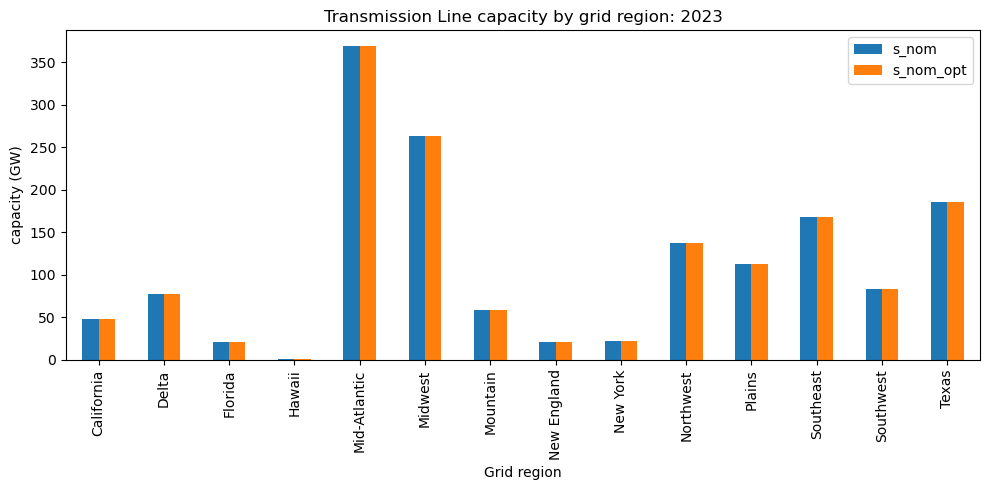


Capacity expansion for scenario_01_2030:


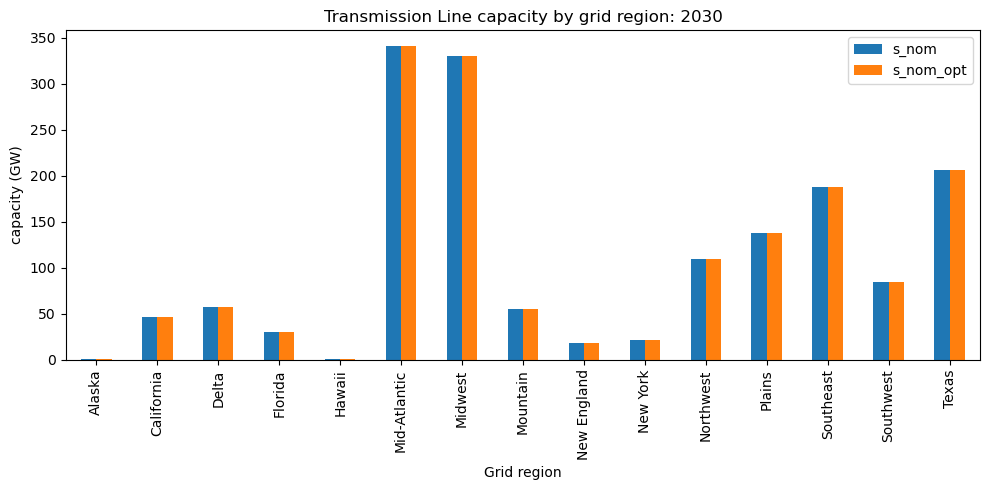


Capacity expansion for scenario_01_2035:


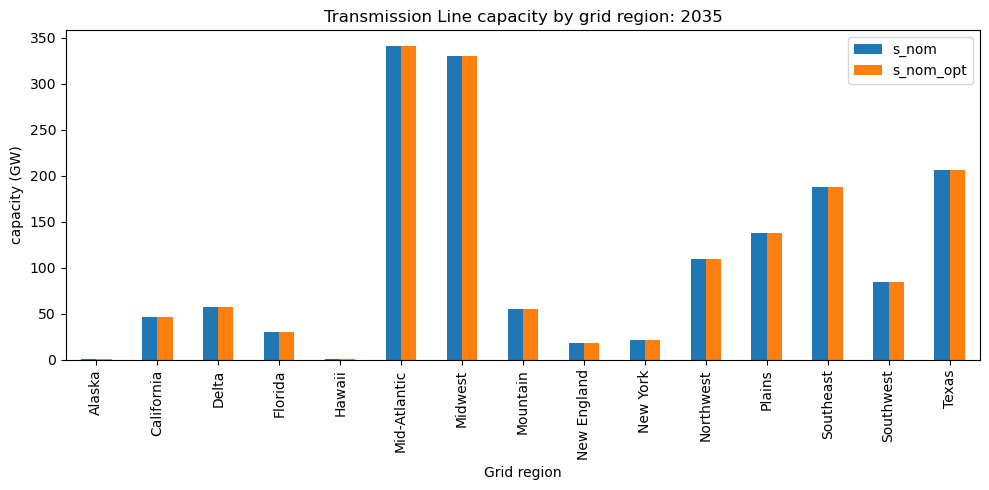


Capacity expansion for scenario_01_2040:


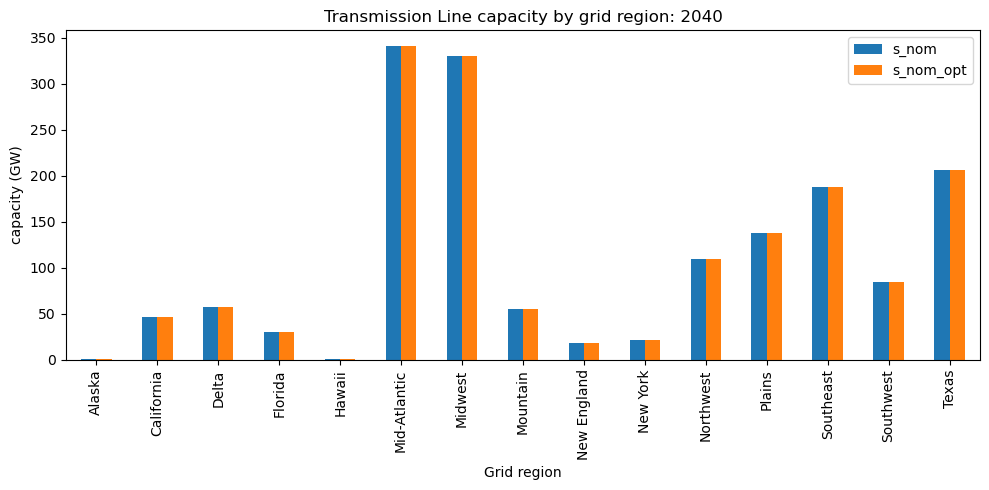

In [24]:
for network_name, n in networks.items():
    print(f"\nCapacity expansion for {network_name}:")
    line_expan_cap = compute_line_expansion_capacity(n)[0]
    
    year = network_name.split('_')[-1]
    line_expan_cap.plot(
        kind="bar",
        title=f"Transmission Line capacity by grid region: {year}",
        ylabel="capacity (GW)",
        xlabel="Grid region",
        figsize=(10, 5),
        legend=True
    )

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


Capacity expansion for Base_2023:


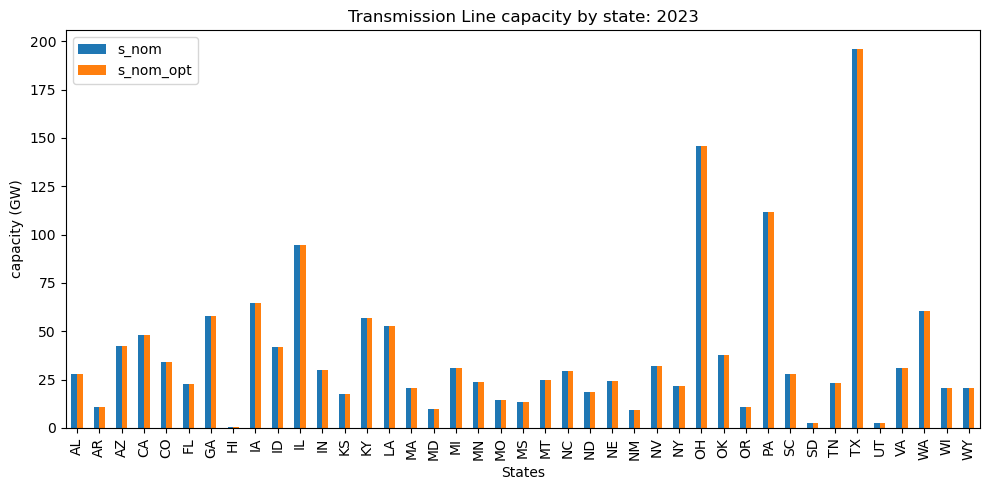

In [ ]:
for network_name, n in networks.items():
    print(f"\nCapacity expansion for {network_name}:")
    line_expan_cap = compute_line_expansion_capacity(n)[1]
    
    year = network_name.split('_')[-1]
    line_expan_cap.plot(
        kind="bar",
        title=f"Transmission Line capacity by state: {year}",
        ylabel="capacity (GW)",
        xlabel="States",
        figsize=(10, 5),
        legend=True
    )

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

### 4.3. Hydrogen production capacity
*This section reports results about installed hydrogen production capacity of the different electrolyzer technologies (e.g., Alkaline, PEM, SOEC).*

In [ ]:
for key, net in networks.items():
    year = key[-4:]
    plot_h2_capacities_map(net, year, tech_colors, nice_names, regions_onshore)

In [ ]:
h2_cap_by_network = {}
max_n_states = 0
max_capacity = 0

for name, network in networks.items():
    h2_cap = compute_h2_capacities(network).groupby('state')[
        ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']
    ].sum()

    filtered = h2_cap[h2_cap.sum(axis=1) > 1]

    h2_cap_by_network[name] = filtered

    if not filtered.empty:
        max_n_states = max(max_n_states, filtered.shape[0])
        max_capacity = max(max_capacity, filtered.sum(axis=1).max())

for name, filtered in h2_cap_by_network.items():
    year = name[-4:]

    if filtered.empty:
        print(f"\nSkipping {year}: no States with capacity > 1 MW\n")
        continue

    plot_h2_capacities_by_state(filtered, year, max_capacity, max_n_states)


In [ ]:
h2_cap_by_network = {}
max_n_grid_regions = 0
max_capacity = 0

for name, network in networks.items():
    h2_cap = compute_h2_capacities(network).groupby('grid_region')[
        ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']
    ].sum()

    filtered = h2_cap[h2_cap.sum(axis=1) > 1]

    h2_cap_by_network[name] = filtered

    if not filtered.empty:
        max_n_grid_regions = max(max_n_grid_regions, filtered.shape[0])
        max_capacity = max(max_capacity, filtered.sum(axis=1).max())

for name, filtered in h2_cap_by_network.items():
    year = name[-4:]

    if filtered.empty:
        print(f"\nSkipping {year}: no Grid Regions with capacity > 1 MW\n")
        continue

    plot_h2_capacities_by_grid_region(filtered, year, max_capacity, max_n_grid_regions)


In [ ]:
for idx, network in enumerate(networks.keys()):
    year = network[-4:]
    
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['state'])[
        ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']
    ].sum()

    print(f"\nInstalled electrolyzer capacity by State (MW) - {year} (only States with capacity ≥ 10 kW)\n")

    df = h2_state_cap.T
    df = df.loc[:, (df >= 0.01).any(axis=0)]

    df.columns.name = "State"
    df.index.name = None

    display(df.style.format("{:.1e}"))

In [ ]:
for idx, network in enumerate(networks.keys()):
    year = network[-4:]
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['grid_region'])[
        ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']
    ].sum()

    print(f"\nInstalled electrolyzer capacity (MW) by Grid Region - {year} (only Grid Regions with capacity ≥ 10 kW))\n")

    df = h2_state_cap.sort_values(by=list(h2_state_cap.columns), ascending=False).T
    df.columns.name = "Grid Region"
    df.index.name = None
    df = df.loc[:, (df >= 0.01).any(axis=0)]

    display(df.style.format("{:.1e}"))

### 4.4. e-kerosene production capacity
*This sector reports information about installed capacity for Fischer-Tropsch synthesis plants for e-kerosene production.*

In [ ]:
ft_state_table = {}

for name, net in networks.items():
    fig, ax, data = create_ft_capacity_by_state_map(
        net.copy(),
        path_shapes=state_shapes_path,
        network_name=name,
        min_capacity_gw=1
    )
    ax.set_aspect('equal', adjustable='datalim')
    plt.show()

    
    # data['grid_region'] = data.bus0.map(n.buses.grid_region)
    ft_state_capacity = data.groupby('state')['p_nom_gw'].sum()
    ft_state_table[name] = ft_state_capacity

In [ ]:
display(Markdown(f"\nInstalled FT capacity by State (GW)\n"))
display(pd.DataFrame(ft_state_table))

In [ ]:
ft_grid_table = {}

for name, net in networks.items():
    fig, ax, data = create_ft_capacity_by_grid_region_map(
        net.copy(),
        path_shapes=grid_region_shapes_path,
        network_name=name,
        min_capacity_gw=1
    )
    ax.set_aspect('equal', adjustable='datalim')
    plt.show()

    ft_grid_table[name] = data.set_index('grid_region')['total_gw']

In [ ]:
display(Markdown(f"\nInstalled FT capacity by Region (GW)\n"))
display(pd.DataFrame(ft_grid_table))

---

##  5. Operational analysis

*This section explores electricity and hydrogen generation and dispatch.*

### 5.1. Electricity dispatch
*Electricity dispatch is assessed for each single source across the model years.*

In [ ]:
summary_list = []
max_y = 0

for key, n in networks.items():
    total_gwh, supply_gw = calculate_dispatch(n)
    summary_list.append({"Network": key, "Total Dispatch (GWh)": total_gwh})
    max_y = max(max_y, supply_gw.sum(axis=1).max())

ymax = max_y

fig, axes = plt.subplots(len(networks), 1, figsize=(22, 5 * len(networks)))

if len(networks) == 1:
    axes = [axes]

for ax, (key, n) in zip(axes, networks.items()):
    _, supply_gw = calculate_dispatch(n)

    supply_gw.index = pd.to_datetime(supply_gw.index)
    supply_gw = supply_gw.resample('24H').mean()
    
    ordered_columns = [
        'nuclear',
        'coal',
        'biomass',
        'CCGT',
        'OCGT',
        'hydro',
        'ror',
        'geothermal',
        'gas CHP',
        'biomass CHP',
        'solar',
        'solar rooftop',
        'csp',
        'onwind',
        'offwind-ac',
        'offwind-dc'
    ]

    supply_gw = supply_gw[[c for c in ordered_columns if c in supply_gw.columns]]

    supply_gw.plot.area(
        ax=ax,
        stacked=True,
        linewidth=0,
        color=[tech_colors.get(c, 'gray') for c in supply_gw.columns],
        legend=False
    )
    
    year = key[-4:]  # Extract the year
    ax.set_title(f"Electricity Dispatch – {year}")
    ax.set_ylabel("Power (GW)")
    ax.set_ylim(0, ymax)
    ax.grid(True)
    
    start = supply_gw.index.min().replace(day=1)
    end = supply_gw.index.max()
    month_starts = pd.date_range(start=start, end=end, freq='MS')
    
    ax.set_xlim(start, end)
    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_starts.strftime('%b'))
    ax.tick_params(axis='x', which='both', labelbottom=True)
    ax.set_xlabel("Time (months)")

    handles, labels = ax.get_legend_handles_labels()
    
    sums = supply_gw.sum()
    
    filtered = [(h, l) for h, l in zip(handles, labels) if sums.get(l, 0) > 0]
    
    if filtered:  # Evita errore se è vuoto
        handles, labels = zip(*filtered)
        pretty_labels = [nice_names.get(label, label) for label in labels]

        ax.legend(
            handles, pretty_labels,
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            title='Technology',
            fontsize='small',
            title_fontsize='medium'
        )


axes[-1].set_xlabel("Time (months)")
plt.tight_layout(rect=[0, 0.05, 0.80, 1])
plt.show()

### 5.2. Electricity generation
*Total electricity generation by source is reported by year, with an indication of the percentage covered by renewable or clean (renewables + nuclear) energy sources per State and at country-wise level.*

In [ ]:
generation_summary = {}

for key, network in networks.items():
    year = key[-4:]  # Extract the year
    generation_summary[year] = calculate_total_generation_by_carrier(network)

generation_df = pd.DataFrame.from_dict(generation_summary, orient='index').fillna(0)
generation_df = generation_df.sort_index().round(2)

generation_df.columns = [nice_names.get(c, c) for c in generation_df.columns]

preferred_order = [
    "Coal", "Oil", "Gas OCGT", "Gas CCGT", "Nuclear", "Biomass", "Conventional hydro", "Run-of-River hydro", "Geothermal", "Utility-scale solar", "Rooftop solar", "Onshore wind", "Offshore wind", "CSP"]

available_cols = generation_df.columns.tolist()
ordered_cols = [c for c in preferred_order if c in available_cols] + \
               [c for c in available_cols if c not in preferred_order]

generation_df = generation_df[ordered_cols]
generation_df["Total"] = generation_df.sum(axis=1).round(2)

print("\nTotal electricity generation (TWh/year) by technology\n")
display(generation_df)


In [70]:
eia_generation_data = pd.read_excel("./validation_data/annual_generation_state.xls", skiprows=1)
eia_generation_data_df = preprocess_res_ces_share_eia(eia_generation_data)[["% ACTUAL RES", "% ACTUAL CES"]]

In [ ]:
ces_path = project_root / "clean_targets.csv"
res_path = project_root / "res_targets.csv"

ces = pd.read_csv(ces_path, index_col=0)
res = pd.read_csv(res_path, index_col=0)

ces.columns = ces.columns.astype(str)
res.columns = res.columns.astype(str)

ces.index = ces.index.str.strip().str.upper()
res.index = res.index.str.strip().str.upper()

res_carriers = ["solar", "onwind", "offwind-ac", "offwind-dc", "ror", "hydro", "geothermal", "solar rooftop"]
ces_carriers = res_carriers + ["nuclear"]

In [ ]:
res_by_network = evaluate_res_ces_by_state(
    networks,
    ces=ces,
    res=res,
    ces_carriers=ces_carriers,
    res_carriers=res_carriers
)

cols_per_row = 4

html_blocks = []

for network_key in sorted(networks.keys()):
    try:
        year = int(network_key[-4:])
    except ValueError:
        continue

    if year in res_by_network:
        if year == 2023:
            df_2023 = res_by_network[2023].copy()
            df_2023.drop(columns=["% RES target", "% CES target"], inplace=True)
            df_2023 = df_2023.merge(eia_generation_data_df, left_index=True, right_index=True)
            df_2023 = df_2023[['% RES', '% ACTUAL RES', '% CES', '% ACTUAL CES']]
            res_by_network[2023] = df_2023
            
        df = res_by_network[year].reset_index()
        df.columns = [""] + list(df.columns[1:])
        df_html = df.to_html(classes="df", border=0, index=False)
        block = f"""
        <div style="flex:1; padding:20px; min-width:300px;">
            <h4 style="text-align:left;">Year: {year}</h4>
            {df_html}
        </div>
        """
        html_blocks.append(block)

rows = [
    "<div style='display:flex; gap:10px; flex-wrap:wrap;'>" +
    "".join(html_blocks[i:i+cols_per_row]) +
    "</div>"
    for i in range(0, len(html_blocks), cols_per_row)
]

print("\nAnalysis of State-wise renewable / clean electricity generation targets")
for row in rows:
    display(HTML(row))


Analysis of State-wise renewable / clean electricity generation targets


,% RES,% RES target,% CES,% CES target
AK,17.1,N/A,17.1,N/A
AL,13.3,N/A,13.3,N/A
AR,4.8,N/A,37.0,N/A
AZ,4.1,N/A,32.8,N/A
CA,49.9,N/A,56.1,N/A
CO,27.4,N/A,27.4,N/A
FL,2.7,N/A,23.9,N/A
GA,4.8,N/A,36.5,N/A
HI,38.2,N/A,38.2,N/A
IA,57.5,N/A,57.5,N/A


In [ ]:
us_html_blocks = []

for network_key in sorted(networks.keys()):
    try:
        year = int(network_key[-4:])
    except ValueError:
        continue

    if year in res_by_network:
        network = networks[network_key]
        year_str = str(year)

        # Total generation
        timestep_h = (network.snapshots[1] - network.snapshots[0]).total_seconds() / 3600
        snapshots_slice = slice(None)

        gen_and_sto_carriers = {
            'csp', 'solar', 'onwind', 'offwind-dc', 'offwind-ac', 'nuclear',
            'geothermal', 'ror', 'hydro', 'solar rooftop'
        }
        link_carriers = ['coal', 'oil', 'OCGT', 'CCGT', 'biomass', 'lignite', 'biomass EOP', 'urban central solid biomass CHP',
                    'urban central solid biomass CHP CC']

        electric_buses = set(
            network.buses.index[
                ~network.buses.carrier.str.contains("heat|gas|H2|oil|coal", case=False, na=False)
            ]
        )

        # Generators
        gen = network.generators[network.generators.carrier.isin(gen_and_sto_carriers)].copy()
        gen["state"] = gen["bus"].map(network.buses["state"])
        gen = gen[gen["state"].notna()]
        gen_p = network.generators_t.p.loc[snapshots_slice, gen.index].clip(lower=0)
        gen_energy = gen_p.multiply(timestep_h).sum()
        gen_energy = gen_energy.to_frame(name="energy_mwh")
        gen_energy["carrier"] = gen.loc[gen_energy.index, "carrier"]
        gen_energy["state"] = gen.loc[gen_energy.index, "state"]

        # Storage
        sto = network.storage_units[network.storage_units.carrier.isin(gen_and_sto_carriers)].copy()
        sto["state"] = sto["bus"].map(network.buses["state"])
        sto = sto[sto["state"].notna()]
        sto_p = network.storage_units_t.p.loc[snapshots_slice, sto.index].clip(lower=0)
        sto_energy = sto_p.multiply(timestep_h).sum()
        sto_energy = sto_energy.to_frame(name="energy_mwh")
        sto_energy["carrier"] = sto.loc[sto_energy.index, "carrier"]
        sto_energy["state"] = sto.loc[sto_energy.index, "state"]

        # Links
        link_data = []
        for i, link in network.links.iterrows():
            if (
                link["carrier"] in link_carriers and
                link["bus1"] in electric_buses and
                pd.notna(network.buses.loc[link["bus1"], "state"])
            ):
                p1 = -network.links_t.p1.loc[snapshots_slice, i].clip(upper=0)
                energy_mwh = p1.sum() * timestep_h
                link_data.append({
                    "carrier": link["carrier"],
                    "state": network.buses.loc[link["bus1"], "state"],
                    "energy_mwh": energy_mwh
                })

        link_energy = pd.DataFrame(link_data)

        # Combine all
        all_energy = pd.concat([
            gen_energy[["carrier", "state", "energy_mwh"]],
            sto_energy[["carrier", "state", "energy_mwh"]],
            link_energy[["carrier", "state", "energy_mwh"]]
        ])

        total_mwh = all_energy["energy_mwh"].sum()
        ces_mwh = all_energy[all_energy["carrier"].isin(ces_carriers)]["energy_mwh"].sum()
        res_mwh = all_energy[all_energy["carrier"].isin(res_carriers)]["energy_mwh"].sum()

        pct_ces = round(100 * ces_mwh / total_mwh, 2)
        pct_res = round(100 * res_mwh / total_mwh, 2)

        # Target US
        if current_scenario in ["scenario_05", "scenario_06"]:
            try:
                ces_target = ces.at["US", year_str]
                ces_target_display = round(ces_target * 100, 2)
            except KeyError:
                ces_target_display = "N/A"
        else:
            ces_target_display = "N/A"

        res_target_display = "N/A"

        us_row = pd.DataFrame({
            "% RES": [pct_res],
            "% RES target": [res_target_display],
            "% CES": [pct_ces],
            "% CES target": [ces_target_display]
        }, index=["US"])
        
        df = us_row.reset_index()
        df.columns = [""] + list(df.columns[1:])
        
        df_html = df.to_html(index=False, classes="df", border=0)
        
        block = f"""
        <div style="flex:1; padding:10px; min-width:300px;">
            <h4 style="text-align:left;">Year: {year}</h4>
            {df_html}
        </div>
        """
        us_html_blocks.append(block)

cols_per_row = 4
rows_us = [
    "<div style='display:flex; gap:20px; flex-wrap:wrap;'>" +
    "".join(us_html_blocks[i:i+cols_per_row]) +
    "</div>"
    for i in range(0, len(us_html_blocks), cols_per_row)
]

print("\nAnalysis of country-wise renewable / clean electricity generation targets")
for row in rows_us:
    display(HTML(row))

### 5.3. Hydrogen dispatch

*Similar to electricity dispatch, the dispatch of hydrogen through the model years is assessed with detail on the technologies used for its production.*

In [ ]:
h2_carriers = [
    "Alkaline electrolyzer large",
    "Alkaline electrolyzer medium",
    "Alkaline electrolyzer small",
    "PEM electrolyzer",
    "SOEC"
]

In [ ]:
plot_hydrogen_dispatch(networks, h2_carriers)

---

## 6. Economic Analysis

*This section shows the evolution of levelized costs of electricity and hydrogen throughout the model time horizon.*

### 6.1. Levelized Cost of Electricity (LCOE)
*The LCOE is assessed at the level of the different US grid regions.*

In [ ]:
grid_regions_shapes = gpd.read_file(grid_region_shapes_path)

In [ ]:
# Collect LCOE values and cache results
all_weighted_lcoe = []
cached_results = {}

for key, net in networks.items():
    lcoe_gdf, table, lcoe_by_bus, lcoe_data, *_ = calculate_lcoe_summary_and_map(net, grid_regions_shapes)
    cached_results[key] = (net, lcoe_gdf, table, lcoe_by_bus, lcoe_data)

    merged = lcoe_by_bus.merge(lcoe_data[['bus', 'energy']], on='bus', how='left')
    grouped = merged.groupby('grid_region').apply(
        lambda df: (df['weighted_lcoe'] * df['energy']).sum() / df['energy'].sum()
    )
    all_weighted_lcoe.extend(grouped.dropna().values)

# Compute global vmin/vmax
vmin = np.quantile(all_weighted_lcoe, 0.05)
vmax = np.quantile(all_weighted_lcoe, 0.95)

# Plot using cached data
plots_data = {}

for key, (net, lcoe_gdf, table, lcoe_by_bus, lcoe_data) in cached_results.items():
    year_match = re.search(r'\d{4}', key)
    year_str = year_match.group() if year_match else "Year N/A"
    title = f"Weighted Average LCOE (USD/MWh) per Grid Region - {year_str}"

    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    plots_data[key] = table

    plot_lcoe_map_by_grid_region(
        lcoe_by_bus, lcoe_data, grid_regions_shapes,
        title=title, key=key, ax=ax,
        vmin=vmin, vmax=vmax
    )

    plt.show()


In [ ]:
def uppercase_only_lcoe_word(df):
    new_cols = {
        col: re.sub(r'\blcoe\b', 'LCOE', col, flags=re.IGNORECASE)
        for col in df.columns
    }
    return df.rename(columns=new_cols)

def apply_nice_names_to_columns_custom(df, mapping):
    sorted_mapping = sorted(mapping.items(), key=lambda item: -len(item[0]))

    placeholder_prefix = "__PLACEHOLDER__"
    placeholder_map = {}
    
    new_cols = []
    for col in df.columns:
        temp_col = col
        for i, (key, val) in enumerate(sorted_mapping):
            if key in temp_col:
                placeholder = f"{placeholder_prefix}{i}__"
                placeholder_map[placeholder] = val
                temp_col = temp_col.replace(key, placeholder)
        new_cols.append(temp_col)
    
    final_cols = [
        reduce(lambda c, p: c.replace(p[0], p[1]), placeholder_map.items(), col)
        for col in new_cols
    ]
    
    df.columns = final_cols
    return df

for net_name, table in plots_data.items():
    year = net_name[-4:]
    print(f"\nYear: ({year})")

    if table.index.name == "grid_region":
        table = table.reset_index()

    table = table.rename(columns={"grid_region": "Grid Region"})

    table.index = pd.Index([""] * len(table))

    table = uppercase_only_lcoe_word(table)
    table = apply_nice_names_to_columns_custom(table, nice_names)

    display(
        table.style.format(precision=2, thousands=",")
    )

In [ ]:
for key, net in networks.items():
    _, _, _, lcoe_data, *_ = calculate_lcoe_summary_and_map(net, grid_regions_shapes)

    region_summary = lcoe_data.groupby(['grid_region', 'bus', 'carrier']).agg(
            dispatch_mwh=('energy', 'sum'),
            total_cost=('lcoe', lambda x: (x * lcoe_data.loc[x.index, 'energy']).sum())
        ).reset_index()

    region_summary['lcoe'] = region_summary['total_cost'] / region_summary['dispatch_mwh']
    region_summary['dispatch'] = region_summary['dispatch_mwh'] / 1e6
    region_summary['bus'] = region_summary['bus'].str.extract(r'(US\d{1} \d{1,2})')

    region_bus_summary = region_summary.pivot(index=['grid_region', 'bus'], columns='carrier', values=['lcoe', 'dispatch'])
    region_bus_summary.columns = [
        f"{carrier} {metric} ({'USD/MWh' if metric == 'lcoe' else 'TWh'})"
        for metric, carrier in region_bus_summary.columns
    ]
    region_bus_summary = region_bus_summary.reset_index()

    dispatch_cols = [col for col in region_bus_summary.columns if 'dispatch' in col.lower()]
    for col in dispatch_cols:
        region_bus_summary[col] = pd.to_numeric(region_bus_summary[col], errors='coerce').fillna(0.0)

    lcoe_cols = [col for col in region_bus_summary.columns if 'lcoe' in col.lower()]

    min_dispatch_threshold = 1  # TWh
    for lcoe_col in lcoe_cols:
        carrier = lcoe_col.split(" ")[0]
        dispatch_col = next((col for col in dispatch_cols if col.startswith(carrier + " ")), None)
        if dispatch_col:
            mask = region_bus_summary[dispatch_col] < min_dispatch_threshold
            region_bus_summary.loc[mask, lcoe_col] = np.nan
    
    table_df = region_bus_summary.groupby(['grid_region']).agg(['min', 'max']).drop(columns=['bus'])

    plot_float_bar_lcoe_dispatch_ranges(table_df, key, nice_names)


In [ ]:
for key, net in networks.items():
    # Recalculate lcoe_data and region_bus_summary
    _, _, _, lcoe_data, *_ = calculate_lcoe_summary_and_map(net, grid_regions_shapes)

    region_summary = lcoe_data.groupby(['grid_region', 'bus', 'carrier']).agg(
        dispatch_mwh=('energy', 'sum'),
        total_cost=('lcoe', lambda x: (x * lcoe_data.loc[x.index, 'energy']).sum())
    ).reset_index()

    region_summary['lcoe'] = region_summary['total_cost'] / region_summary['dispatch_mwh']
    region_summary['dispatch'] = region_summary['dispatch_mwh'] / 1e6
    region_summary['bus'] = region_summary['bus'].str.extract(r'(US\d{1} \d{1,2})')

    region_bus_summary = region_summary.pivot(index=['grid_region', 'bus'], columns='carrier', values=['lcoe', 'dispatch'])
    region_bus_summary.columns = [
        f"{carrier} {metric} ({'USD/MWh' if metric == 'lcoe' else 'TWh'})"
        for metric, carrier in region_bus_summary.columns
    ]
    region_bus_summary = region_bus_summary.reset_index()

    # Convert dispatch to numeric and apply threshold filtering to LCOE
    dispatch_cols = [col for col in region_bus_summary.columns if 'dispatch' in col.lower()]
    lcoe_cols = [col for col in region_bus_summary.columns if 'lcoe' in col.lower()]
    
    for col in dispatch_cols:
        region_bus_summary[col] = pd.to_numeric(region_bus_summary[col], errors='coerce').fillna(0.0)

    min_dispatch_threshold = 1  # TWh
    for lcoe_col in lcoe_cols:
        carrier = lcoe_col.split(" ")[0]
        dispatch_col = next((col for col in dispatch_cols if col.startswith(carrier + " ")), None)
        if dispatch_col:
            mask = region_bus_summary[dispatch_col] < min_dispatch_threshold
            region_bus_summary.loc[mask, lcoe_col] = np.nan

    # --- NATIONAL PLOT ONLY ---
    national_data = region_bus_summary.drop(columns=['grid_region', 'bus'])
    lcoe_columns = [col for col in national_data.columns if 'lcoe' in col.lower()]
    national_data = national_data[lcoe_columns]

    national_min = national_data.min()
    national_max = national_data.max()

    arrays = [[col for col in national_min.index] * 2, ['min'] * len(national_min) + ['max'] * len(national_max)]
    multi_cols = pd.MultiIndex.from_tuples(zip(*arrays))

    national_values = pd.concat([national_min, national_max])
    national_df = pd.DataFrame([national_values.values], columns=multi_cols, index=['USA'])

    display(Markdown("\n**Note:** The LCOE values reported here also include existing nuclear plants, many of which are already amortized and were built under different historical cost conditions. In contrast, Lazard’s estimates reflect newly built projects with current capital costs and construction standards, which explains the higher LCOE values."))
    plot_float_bar_lcoe_dispatch_ranges(national_df, key, nice_names)


### 6.2. Levelized Cost of Hydrogen (LCOH)
*The levelized cost of hydrogen is assessed at the level of the different US Grid Regions.*

In [ ]:
plot_lcoh_maps_by_grid_region(networks, grid_regions_shapes, h2_carriers, output_threshold=100) # Threshodld in MWh/year

In [ ]:
tables_by_year = calculate_weighted_lcoh_table_by_year(networks, h2_carriers, output_threshold=100) # Threshdld in MWh/year

pd.options.display.float_format = '{:,.2f}'.format

for year, table in tables_by_year.items():
    print(f"\n Year: {year} \n")
    table.index = pd.Index([""] * len(table))
    display(table)

---

## 7. E-Kerosene

*This section is dedicated to the analysis of e-kerosene production and costs.*

In [ ]:
df = compute_aviation_fuel_demand(networks)

styled_df = (
    df.style
    .hide(axis="index")
    .format({
        "Kerosene (TWh)": "{:,.2f}",
        "e-Kerosene (TWh)": "{:,.2f}",
        "Total (TWh)": "{:,.2f}",
        "e-Kerosene Share (%)": "{:.1f}%",
    })
    .set_properties(**{"text-align": "right", "font-size": "13px"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "right"), ("font-size", "12px")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold"), ("font-size", "16px")]}
    ])
)

print("\nAviation fuel demand\n")
display(styled_df)


In [ ]:
# Run calculation
ft_df = calculate_total_inputs_outputs_ft(networks)

print("\nElectricity / hydrogen / CO2 balance for e-kerosene production \n")

# Display without index
display(ft_df.style.hide(axis="index").format(precision=2))


In [ ]:
compute_ekerosene_production_cost_by_region(networks)

A CO2 marginal cost = 0 is due to the fact that this CO2 is a byproduct of another processes (e.g. bioethanol production, in this specific case) whose costs are already accounted for. Since there's no scarcity or competing demand, the marginal price of CO2 may be considered as null.

---

## 8. Industrial sector analysis

## 8.1 Industrial production
This section focuses on the production from the different industrial sectors related to e-kerosene production (point-source CO2).

In [ ]:
carriers_of_interest = ['NH3', 'ethanol', 'DRI', 'steel BF-BOF', 'steel EAF', 'cement']

In [ ]:
# Specific conversion per carrier
conversion_factors = {
    "cement": (1 / 1000, "kt/year"),
    "DRI": (1 / 1000, "kt/year"),
    "steel BF-BOF": (1 / 1000, "kt/year"),
    "steel EAF": (1 / 1000, "kt/year"),
    "ethanol": (1/ 80.2 * 3600 / 1e6, "MMgallon/year"),
    "NH3": (1/ 5.17 / 1e3, "thousand metric tons/year"), 
}

summary_all = {}
units = {}

for name, network in networks.items(): 

    filtered_loads = network.loads[network.loads["carrier"].isin(carriers_of_interest)].copy()

    filtered_loads["state"] = filtered_loads["bus"].map(network.buses["state"])

    summary = (
        filtered_loads.groupby("carrier")["p_set"]
        .sum()
        .mul(8760)  # convert from MW to MWh/year
        .reindex(carriers_of_interest)
        .fillna(0)
    )

    converted = []
    unit_column = []
    for carrier in carriers_of_interest:
        value = summary.get(carrier, 0)
        factor, unit = conversion_factors.get(carrier, (1, "MWh/year"))
        converted.append(round(value * factor, 2))
        unit_column.append(unit)

    summary_converted = pd.Series(converted, index=carriers_of_interest)
    year = name[-4:]  # Extract year from network name
    summary_all[year] = summary_converted

    if "Unit" not in units:
        units["Unit"] = unit_column 

summary_df = pd.DataFrame(summary_all)
summary_df["Unit"] = units["Unit"]

pd.set_option('display.float_format', '{:,.1f}'.format)

print("\nTotal production by industrial product\n")
display(summary_df)

## 8.2 Industrial emissions
This section focuses on the analysis of the CO2 commodity, with particular reference to the industrial sector and the use for e-kerosene production.

In [ ]:
for key, net in networks.items():

    year = key[-4:]
    print(f"\nYear: {year}\n")

    df = compute_emissions_from_links(net)

    # Filter rows with emissions != 0 only
    df_nonzero = df[
        (df["co2_atmosphere [Mt CO2]"] != 0) |
        (df["co2_stored [Mt CO2]"] != 0) |
        (df["net_emissions [Mt CO2]"] != 0)
    ]

    df_renamed = df_nonzero.rename(columns={
        "co2_atmosphere [Mt CO2]": "CO2 to Atmosphere (Mt CO2/year)",
        "co2_stored [Mt CO2]": "CO2 Stored (Mt CO2)",
        "net_emissions [Mt CO2]": "Net CO2 Emissions (Mt CO2/year)",
        "carrier": "Process",
    })

    # Set Net CO2 Emissions to 0 where CO2 Stored is positive
    df_renamed.loc[df_renamed["CO2 Stored (Mt CO2)"] > 0, "Net CO2 Emissions (Mt CO2/year)"] = 0

    display(df_renamed.style.format(precision=2).hide(axis="index"))

In [ ]:
carrier_groups = {
    "BF-BOF": ["BF-BOF", "BF-BOF CC"],
    "DRI": ["DRI", "DRI CC"],
    "ethanol": ["ethanol from starch", "ethanol from starch CC"],
    "SMR": ["SMR", "SMR CC"],
    "dry clinker": ["dry clinker", "dry clinker CC"]
}

In [ ]:
for key, net in networks.items():
    
    year = key[-4:]
    print(f"\nYear: {year}\n")

    df_summary = compute_emissions_grouped(net, carrier_groups)

    df_filtered = df_summary[
        (df_summary[["co2_atmosphere [Mt CO2]", "co2_stored [Mt CO2]", "net_emissions [Mt CO2]"]]
         .abs().sum(axis=1) > 0)
    ].copy()

    for col in ["co2_atmosphere [Mt CO2]", "co2_stored [Mt CO2]", "net_emissions [Mt CO2]"]:
        df_filtered[col] = df_filtered[col].apply(lambda x: 0.0 if abs(x) < 1e-6 else x)

    df_filtered = df_filtered.rename(columns={
        "carrier_group": "Industrial technology group",
        "co2_atmosphere [Mt CO2]": "CO2 to atmosphere (Mt CO2/year)",
        "co2_stored [Mt CO2]": "CO2 Stored (Mt CO2/year)",
        "net_emissions [Mt CO2]": "Net CO2 Emissions (Mt CO2/year)"
    })

    df_filtered.loc[df_filtered["CO2 Stored (Mt CO2/year)"] > 0, "Net CO2 Emissions (Mt CO2/year)"] = 0

    biogenic_only = any(s in key for s in ["scenario_05", "scenario_06", "scenario_10", "scenario_10_transmission_expansion"])

    if biogenic_only:
        total_stored = df_filtered[df_filtered["Industrial technology group"] == "ethanol"]["CO2 Stored (Mt CO2/year)"].sum()
        note = " (biogenic CO2 only)"
    else:
        total_stored = df_filtered["CO2 Stored (Mt CO2/year)"].sum()
        note = ""

    print(f"Total CO2 stored (available for e-kerosene production){note}: {total_stored:.2f} Mt CO2\n")
    display(df_filtered.style.format(precision=2).hide(axis="index"))

In [ ]:
all_dfs = []
global_max = 0

for name, net in networks.items():
    df = compute_emissions_by_state(net, carrier_groups)
    df["scenario"] = name
    all_dfs.append(df)

    max_val = df["net_emissions"].abs().max()
    if max_val > global_max:
        global_max = max_val

for df in all_dfs:
    scenario = df["scenario"].iloc[0]
    year = scenario[-4:]
    df_plot = df.rename(columns={"state": "State"})
    plot_emissions_maps_by_group(df_plot, state_shapes_path, year, vmin=-global_max, vmax=global_max)